# DA039 Preprocess
Created: 06/21/2024 \
Updated: 06/23/2024

*modified elec labels to make sense*


In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
from ast import literal_eval


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/' #### FIRST LOAD USE _RAW, THEN USE _LABELS.CSV AFTER EDITS
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'DA039'
subj_format = ['edf']
subj_site = ['UCD']


In [6]:
#### print date of last run
date = datetime.date.today().strftime('%m%d%Y')
print(date)

06232024


# Make mne_data


### Load and resample data


In [7]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA039/raw/DA039_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4772095  =      0.000 ...  2330.125 secs...


In [8]:
mne_data

<RawEDF | DA039_SWB.edf, 143 x 4772096 (2330.1 s), ~5.08 GB, data loaded>

In [9]:
mne_data.ch_names

['A1',
 'A2',
 'A3',
 'A4',
 'A5',
 'A6',
 'A7',
 'A8',
 'A9',
 'A10',
 'A11',
 'A12',
 'A13',
 'A14',
 'A15',
 'B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'TP1',
 'TP2',
 'TP3',
 'TP4',
 'TP5',
 'TP6',
 'TP7',
 'TP8',
 'TP9',
 'TP10',
 'TP11',
 'TP12',
 'U1',
 'U2',
 'U3',
 'U4',
 'U5',
 'U6',
 'U7',
 'U8',
 'OF1',
 'OF2',
 'OF3',
 'OF4',
 'OF5',
 'OF6',
 'OF7',
 'OF8',
 'OF9',
 'OF10',
 'OF11',
 'OF12',
 'OF13',
 'OF14',
 'OF15',
 'FP1',
 'FP2',
 'FP3',
 'FP4',
 'FP5',
 'FP6',
 'FP7',
 'FP8',
 'FP9',
 'FP10',
 'FP11',
 'FP12',
 'AI1',
 'AI2',
 'AI3',
 'AI4',
 'AI5',
 'AI6',
 'AI7',
 'AI8',
 'AI9',
 'AI10',
 'AI11',
 'AI12',
 'PI1',
 'PI2',
 'PI3',
 'PI4',
 'PI5',
 'PI6',
 'PI7',
 'PI8',
 'PI9',
 'PI10',
 'DP1',
 'DP2',
 'DP3',
 'DP4',
 'DP5',
 'DP6',
 'DP7',
 'DP8',
 'MP1',
 'MP2',
 'MP3',
 'MP4',
 'MP5',
 'MP6',
 'MP7',
 'MP8',
 'VP1',
 'VP2',
 'VP3',
 'VP4',
 'VP5',
 'VP6',
 'VP7',
 'VP8',
 'Z1',
 'Z2',
 'Z3',
 'Z4',
 'Z5',
 'Z6',
 'Z7',
 'Z8',
 'N1',
 'N2',
 'N3',
 'N4

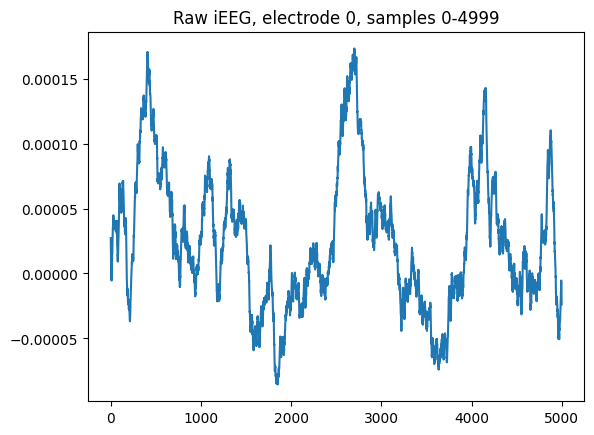

In [10]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [11]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:  1.4min finished


<RawEDF | DA039_SWB.edf, 143 x 1165062 (2330.1 s), ~1.24 GB, data loaded>

### Notch filter line noise

In [12]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 143 out of 143 | elapsed:    7.6s finished


<RawEDF | DA039_SWB.edf, 143 x 1165062 (2330.1 s), ~1.24 GB, data loaded>

### Photodiode
- examine photodiode 

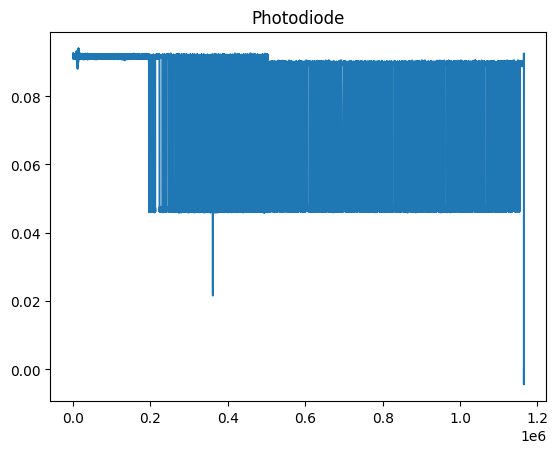

In [13]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC2")
plt.plot(mne_data._data[trig_ix])
# plt.xlim([400000,500000]) ### inverted!!
plt.title("Photodiode")
plt.show()

In [14]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC2', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA039/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA039/photodiode.fif
[done]


In [15]:
mne_data.drop_channels(['DC2'])

<RawEDF | DA039_SWB.edf, 142 x 1165062 (2330.1 s), ~1.23 GB, data loaded>

# Anatomical Localization + CHANNEL NAME CLEANING!

In [49]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | DA039_SWB.edf, 142 x 1165062 (2330.1 s), ~1.23 GB, data loaded>

In [50]:
new_name_dict

{'a1': 'a1',
 'a2': 'a2',
 'a3': 'a3',
 'a4': 'a4',
 'a5': 'a5',
 'a6': 'a6',
 'a7': 'a7',
 'a8': 'a8',
 'a9': 'a9',
 'a10': 'a10',
 'a11': 'a11',
 'a12': 'a12',
 'a13': 'a13',
 'a14': 'a14',
 'a15': 'a15',
 'b1': 'b1',
 'b2': 'b2',
 'b3': 'b3',
 'b4': 'b4',
 'b5': 'b5',
 'b6': 'b6',
 'b7': 'b7',
 'b8': 'b8',
 'tp1': 'tp1',
 'tp2': 'tp2',
 'tp3': 'tp3',
 'tp4': 'tp4',
 'tp5': 'tp5',
 'tp6': 'tp6',
 'tp7': 'tp7',
 'tp8': 'tp8',
 'tp9': 'tp9',
 'tp10': 'tp10',
 'tp11': 'tp11',
 'tp12': 'tp12',
 'u1': 'u1',
 'u2': 'u2',
 'u3': 'u3',
 'u4': 'u4',
 'u5': 'u5',
 'u6': 'u6',
 'u7': 'u7',
 'u8': 'u8',
 'of1': 'of1',
 'of2': 'of2',
 'of3': 'of3',
 'of4': 'of4',
 'of5': 'of5',
 'of6': 'of6',
 'of7': 'of7',
 'of8': 'of8',
 'of9': 'of9',
 'of10': 'of10',
 'of11': 'of11',
 'of12': 'of12',
 'of13': 'of13',
 'of14': 'of14',
 'of15': 'of15',
 'fp1': 'fp1',
 'fp2': 'fp2',
 'fp3': 'fp3',
 'fp4': 'fp4',
 'fp5': 'fp5',
 'fp6': 'fp6',
 'fp7': 'fp7',
 'fp8': 'fp8',
 'fp9': 'fp9',
 'fp10': 'fp10',
 'fp11': '

In [51]:
# Load the electrode localization data
###### LABELS FILE IS _RAW BECAUSE THE CHANNELS HAVEN'T BEEN RENAMED LOGICALLY YET!

anat_file = glob(f'{anat_dir}{subj_id}_labels_new.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]
elec_locs.label = [elec.strip().replace(" ", "") for elec in elec_locs.label.tolist()]

elec_locs

label BN246label          x          y          z      mni_x      mni_y  \
0      A1    mAmyg_R  17.184297  10.199994 -14.607567  19.644796  -4.261305   
1     A10     aSTS_R  48.755468   9.799994 -17.002517  50.336746  -3.791582   
2     A11     aSTS_R  52.352184   9.799994 -17.401676  53.913322  -3.447258   
3     A12     aSTS_R  56.348535   9.799994 -17.401676  57.825592  -3.025602   
4     A13     aSTS_R  59.545615   9.799994 -17.800834  60.938914  -2.717300   
..    ...        ...        ...        ...        ...        ...        ...   
137    Z4     A8vl_R  47.956198  27.799993  40.875445  47.123769  20.560695   
138    Z5     A8vl_R  51.552914  27.799993  41.673761  50.703374  20.786130   
139    Z6    Unknown  55.549264  27.799993  42.472078  54.730776  21.135028   
140    Z7    Unknown  59.545615  27.799993  43.270395  58.773009  21.517388   
141    Z8    Unknown  62.343061  27.399993  43.669553  61.616760  21.381680   

         mni_z       gm                                NMM           Anat  \
0   -18.186099     Gray                     Right Amygdala  Amygdala (SF)   
1   -19.700849     Gray  Right STG superior temporal gyrus        Unknown   
2   -19.747651     Gray    Right MTG middle temporal gyrus        Unknown   
3   -19.296593     Gray    Right MTG middle temporal gyrus        Unknown   
4   -19.327170     Gray    Right MTG middle temporal gyrus      Area TE 3   
..         ...      ...                                ...            ...   
137  42.539767  Unknown     Right MFG middle frontal gyrus        Unknown   
138  43.652692  Unknown     Right MFG middle frontal gyrus        Unknown   
139  44.936908  Unknown                            Unknown        Unknown   
140  46.278242  Unknown                            Unknown        Unknown   
141  47.091338  Unknown                            Unknown        Unknown   

                   AnatMacro    BN246                                   YBA_1  \
0              R Hippocampus   R Amyg                Right amygdala superior    
1    R Middle Temporal Gyrus    R MTG  Right superior middle temporal gyrus A   
2    R Middle Temporal Gyrus    R MTG  Right superior middle temporal gyrus A   
3    R Middle Temporal Gyrus    R MTG  Right superior middle temporal gyrus A   
4    R Middle Temporal Gyrus    R MTG  Right superior middle temporal gyrus A   
..                       ...      ...                                     ...   
137   R Middle Frontal Gyrus    R MFG          Right middle frontal gyrus 5 B   
138   R Middle Frontal Gyrus    R MFG                                 Unknown   
139                  Unknown  Unknown                                 Unknown   
140                  Unknown  Unknown                                 Unknown   
141                  Unknown  Unknown                                 Unknown   

    ManualExamination new_labels  
0                 NaN       RAM1  
1                 NaN      RAM10  
2                 NaN      RAM11  
3                 NaN      RAM12  
4                 NaN      RAM13  
..                ...        ...  
137               OOB      RmGL4  
138               OOB      RmGL5  
139               OOB      RmGL6  
140               OOB      RmGL7  
141               OOB      RmGL8  

[142 rows x 16 columns]

In [52]:
list(elec_locs.label)

['A1',
 'A10',
 'A11',
 'A12',
 'A13',
 'A14',
 'A15',
 'A2',
 'A3',
 'A4',
 'A5',
 'A6',
 'A7',
 'A8',
 'A9',
 'AI1',
 'AI10',
 'AI11',
 'AI12',
 'AI2',
 'AI3',
 'AI4',
 'AI5',
 'AI6',
 'AI7',
 'AI8',
 'AI9',
 'B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'DP1',
 'DP2',
 'DP3',
 'DP4',
 'DP5',
 'DP6',
 'DP7',
 'DP8',
 'FP1',
 'FP10',
 'FP11',
 'FP12',
 'FP2',
 'FP3',
 'FP4',
 'FP5',
 'FP6',
 'FP7',
 'FP8',
 'FP9',
 'MP1',
 'MP2',
 'MP3',
 'MP4',
 'MP5',
 'MP6',
 'MP7',
 'MP8',
 'N1',
 'N2',
 'N3',
 'N4',
 'N5',
 'N6',
 'N7',
 'N8',
 'OF1',
 'OF10',
 'OF11',
 'OF12',
 'OF13',
 'OF14',
 'OF15',
 'OF2',
 'OF3',
 'OF4',
 'OF5',
 'OF6',
 'OF7',
 'OF8',
 'OF9',
 'PI1',
 'PI10',
 'PI2',
 'PI3',
 'PI4',
 'PI5',
 'PI6',
 'PI7',
 'PI8',
 'PI9',
 'S1',
 'S10',
 'S2',
 'S3',
 'S4',
 'S5',
 'S6',
 'S7',
 'S8',
 'S9',
 'TP1',
 'TP10',
 'TP11',
 'TP12',
 'TP2',
 'TP3',
 'TP4',
 'TP5',
 'TP6',
 'TP7',
 'TP8',
 'TP9',
 'U1',
 'U2',
 'U3',
 'U4',
 'U5',
 'U6',
 'U7',
 'U8',
 'VP1',
 'VP2',
 '

In [53]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

[]


In [54]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


In [55]:
unmatched_seeg #make sure there are no unmatched names


[]

In [56]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [57]:
new_name_dict #make sure this passes the eye test 


{'a1': 'a1',
 'a2': 'a2',
 'a3': 'a3',
 'a4': 'a4',
 'a5': 'a5',
 'a6': 'a6',
 'a7': 'a7',
 'a8': 'a8',
 'a9': 'a9',
 'a10': 'a10',
 'a11': 'a11',
 'a12': 'a12',
 'a13': 'a13',
 'a14': 'a14',
 'a15': 'a15',
 'b1': 'b1',
 'b2': 'b2',
 'b3': 'b3',
 'b4': 'b4',
 'b5': 'b5',
 'b6': 'b6',
 'b7': 'b7',
 'b8': 'b8',
 'tp1': 'tp1',
 'tp2': 'tp2',
 'tp3': 'tp3',
 'tp4': 'tp4',
 'tp5': 'tp5',
 'tp6': 'tp6',
 'tp7': 'tp7',
 'tp8': 'tp8',
 'tp9': 'tp9',
 'tp10': 'tp10',
 'tp11': 'tp11',
 'tp12': 'tp12',
 'u1': 'u1',
 'u2': 'u2',
 'u3': 'u3',
 'u4': 'u4',
 'u5': 'u5',
 'u6': 'u6',
 'u7': 'u7',
 'u8': 'u8',
 'of1': 'of1',
 'of2': 'of2',
 'of3': 'of3',
 'of4': 'of4',
 'of5': 'of5',
 'of6': 'of6',
 'of7': 'of7',
 'of8': 'of8',
 'of9': 'of9',
 'of10': 'of10',
 'of11': 'of11',
 'of12': 'of12',
 'of13': 'of13',
 'of14': 'of14',
 'of15': 'of15',
 'fp1': 'fp1',
 'fp2': 'fp2',
 'fp3': 'fp3',
 'fp4': 'fp4',
 'fp5': 'fp5',
 'fp6': 'fp6',
 'fp7': 'fp7',
 'fp8': 'fp8',
 'fp9': 'fp9',
 'fp10': 'fp10',
 'fp11': '

In [58]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | DA039_SWB.edf, 142 x 1165062 (2330.1 s), ~1.23 GB, data loaded>

In [59]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in mne_data.ch_names}
mne_data.set_channel_types(sEEG_mapping_dict)

<RawEDF | DA039_SWB.edf, 142 x 1165062 (2330.1 s), ~1.23 GB, data loaded>

In [60]:
mne_data.ch_names

['a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a7',
 'a8',
 'a9',
 'a10',
 'a11',
 'a12',
 'a13',
 'a14',
 'a15',
 'b1',
 'b2',
 'b3',
 'b4',
 'b5',
 'b6',
 'b7',
 'b8',
 'tp1',
 'tp2',
 'tp3',
 'tp4',
 'tp5',
 'tp6',
 'tp7',
 'tp8',
 'tp9',
 'tp10',
 'tp11',
 'tp12',
 'u1',
 'u2',
 'u3',
 'u4',
 'u5',
 'u6',
 'u7',
 'u8',
 'of1',
 'of2',
 'of3',
 'of4',
 'of5',
 'of6',
 'of7',
 'of8',
 'of9',
 'of10',
 'of11',
 'of12',
 'of13',
 'of14',
 'of15',
 'fp1',
 'fp2',
 'fp3',
 'fp4',
 'fp5',
 'fp6',
 'fp7',
 'fp8',
 'fp9',
 'fp10',
 'fp11',
 'fp12',
 'ai1',
 'ai2',
 'ai3',
 'ai4',
 'ai5',
 'ai6',
 'ai7',
 'ai8',
 'ai9',
 'ai10',
 'ai11',
 'ai12',
 'pi1',
 'pi2',
 'pi3',
 'pi4',
 'pi5',
 'pi6',
 'pi7',
 'pi8',
 'pi9',
 'pi10',
 'dp1',
 'dp2',
 'dp3',
 'dp4',
 'dp5',
 'dp6',
 'dp7',
 'dp8',
 'mp1',
 'mp2',
 'mp3',
 'mp4',
 'mp5',
 'mp6',
 'mp7',
 'mp8',
 'vp1',
 'vp2',
 'vp3',
 'vp4',
 'vp5',
 'vp6',
 'vp7',
 'vp8',
 'z1',
 'z2',
 'z3',
 'z4',
 'z5',
 'z6',
 'z7',
 'z8',
 'n1',
 'n2',
 'n3',
 'n4

In [61]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | DA039_SWB.edf, 142 x 1165062 (2330.1 s), ~1.23 GB, data loaded>

In [62]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [63]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [64]:
probe_ch_counts

{'a': 15,
 'ai': 12,
 'b': 8,
 'dp': 8,
 'fp': 12,
 'mp': 8,
 'n': 8,
 'of': 15,
 'pi': 10,
 's': 10,
 'tp': 12,
 'u': 8,
 'vp': 8,
 'z': 8}

## CLEAN MNE LABELS TO MAKE SENSE

In [65]:
# new_anat_df            = pd.read_csv(glob(f'{anat_dir}{subj_id}_labels_new.csv')[0])
# elec_locs.old_labels = elec_locs.old_labels.str.lower()
elec_locs.new_labels    = elec_locs.new_labels.str.lower()
elec_locs.label         = elec_locs.label.str.lower()
elec_locs['old_labels'] = elec_locs.label.copy()
elec_locs.old_labels    = [elec.strip().replace(" ", "") for elec in elec_locs.old_labels]
elec_locs

label BN246label          x          y          z      mni_x      mni_y  \
0      a1    mAmyg_R  17.184297  10.199994 -14.607567  19.644796  -4.261305   
1     a10     aSTS_R  48.755468   9.799994 -17.002517  50.336746  -3.791582   
2     a11     aSTS_R  52.352184   9.799994 -17.401676  53.913322  -3.447258   
3     a12     aSTS_R  56.348535   9.799994 -17.401676  57.825592  -3.025602   
4     a13     aSTS_R  59.545615   9.799994 -17.800834  60.938914  -2.717300   
..    ...        ...        ...        ...        ...        ...        ...   
137    z4     A8vl_R  47.956198  27.799993  40.875445  47.123769  20.560695   
138    z5     A8vl_R  51.552914  27.799993  41.673761  50.703374  20.786130   
139    z6    Unknown  55.549264  27.799993  42.472078  54.730776  21.135028   
140    z7    Unknown  59.545615  27.799993  43.270395  58.773009  21.517388   
141    z8    Unknown  62.343061  27.399993  43.669553  61.616760  21.381680   

         mni_z       gm                                NMM           Anat  \
0   -18.186099     Gray                     Right Amygdala  Amygdala (SF)   
1   -19.700849     Gray  Right STG superior temporal gyrus        Unknown   
2   -19.747651     Gray    Right MTG middle temporal gyrus        Unknown   
3   -19.296593     Gray    Right MTG middle temporal gyrus        Unknown   
4   -19.327170     Gray    Right MTG middle temporal gyrus      Area TE 3   
..         ...      ...                                ...            ...   
137  42.539767  Unknown     Right MFG middle frontal gyrus        Unknown   
138  43.652692  Unknown     Right MFG middle frontal gyrus        Unknown   
139  44.936908  Unknown                            Unknown        Unknown   
140  46.278242  Unknown                            Unknown        Unknown   
141  47.091338  Unknown                            Unknown        Unknown   

                   AnatMacro    BN246                                   YBA_1  \
0              R Hippocampus   R Amyg                Right amygdala superior    
1    R Middle Temporal Gyrus    R MTG  Right superior middle temporal gyrus A   
2    R Middle Temporal Gyrus    R MTG  Right superior middle temporal gyrus A   
3    R Middle Temporal Gyrus    R MTG  Right superior middle temporal gyrus A   
4    R Middle Temporal Gyrus    R MTG  Right superior middle temporal gyrus A   
..                       ...      ...                                     ...   
137   R Middle Frontal Gyrus    R MFG          Right middle frontal gyrus 5 B   
138   R Middle Frontal Gyrus    R MFG                                 Unknown   
139                  Unknown  Unknown                                 Unknown   
140                  Unknown  Unknown                                 Unknown   
141                  Unknown  Unknown                                 Unknown   

    ManualExamination new_labels old_labels  
0                 NaN       ram1         a1  
1                 NaN      ram10        a10  
2                 NaN      ram11        a11  
3                 NaN      ram12        a12  
4                 NaN      ram13        a13  
..                ...        ...        ...  
137               OOB      rmgl4         z4  
138               OOB      rmgl5         z5  
139               OOB      rmgl6         z6  
140               OOB      rmgl7         z7  
141               OOB      rmgl8         z8  

[142 rows x 17 columns]

In [120]:
# new_anat_df[new_anat_df.label.str.contains('rpins')]

In [66]:

new_ch_names = list(elec_locs.new_labels.str.lower())
pattern = '[0-9]'
new_ch_names_no_num = [re.sub(pattern, '', i) for i in new_ch_names]
new_probe_names = np.unique(new_ch_names_no_num)
new_probe_names

array(['ai', 'rac', 'rains', 'ram', 'rdgl', 'rfp', 'rhh', 'rmfg', 'rmgl',
       'rof', 'rpins', 'rpmot', 'rsgcc', 'rtp', 'rvmot'], dtype='<U5')

In [67]:
orig_probes = probe_names.copy()



In [68]:
elec_locs.new_labels.str.lower().tolist()

['ram1',
 'ram10',
 'ram11',
 'ram12',
 'ram13',
 'ram14',
 'ram15',
 'ram2',
 'ram3',
 'ram4',
 'ram5',
 'ram6',
 'ram7',
 'ram8',
 'ram9',
 'rains1',
 'rains10',
 'ai11',
 'rains12',
 'rains2',
 'rains3',
 'rains4',
 'rains5',
 'rains6',
 'rains7',
 'rains8',
 'rains9',
 'rhh1',
 'rhh2',
 'rhh3',
 'rhh4',
 'rhh5',
 'rhh6',
 'rhh7',
 'rhh8',
 'rdgl1',
 'rdgl2',
 'rdgl3',
 'rdgl4',
 'rdgl5',
 'rdgl6',
 'rdgl7',
 'rdgl8',
 'rfp1',
 'rfp10',
 'rfp11',
 'rfp12',
 'rfp2',
 'rfp3',
 'rfp4',
 'rfp5',
 'rfp6',
 'rfp7',
 'rfp8',
 'rfp9',
 'rmfg1',
 'rmfg2',
 'rmfg3',
 'rmfg4',
 'rmfg5',
 'rmfg6',
 'rmfg7',
 'rmfg8',
 'rpmot1',
 'rpmot2',
 'rpmot3',
 'rpmot4',
 'rpmot5',
 'rpmot6',
 'rpmot7',
 'rpmot8',
 'rof1',
 'rof10',
 'rof11',
 'rof12',
 'rof13',
 'rof14',
 'rof15',
 'rof2',
 'rof3',
 'rof4',
 'rof5',
 'rof6',
 'rof7',
 'rof8',
 'rof9',
 'rpins1',
 'rpins10',
 'rpins2',
 'rpins3',
 'rpins4',
 'rpins5',
 'rpins6',
 'rpins7',
 'rpins8',
 'rpins9',
 'rac1',
 'rac10',
 'rac2',
 'rac3',
 'rac4'

In [69]:
elec_locs.old_labels

0       a1
1      a10
2      a11
3      a12
4      a13
      ... 
137     z4
138     z5
139     z6
140     z7
141     z8
Name: old_labels, Length: 142, dtype: object

In [77]:
### CREATE MAPPING DICT TO RENAME MNE CHANNELS

fix_mne_labels = {x:y for (x,y) in zip(elec_locs.old_labels.str.lower().tolist(), 
                                       elec_locs.new_labels.str.lower().tolist())}
fix_mne_labels

{'a1': 'ram1',
 'a10': 'ram10',
 'a11': 'ram11',
 'a12': 'ram12',
 'a13': 'ram13',
 'a14': 'ram14',
 'a15': 'ram15',
 'a2': 'ram2',
 'a3': 'ram3',
 'a4': 'ram4',
 'a5': 'ram5',
 'a6': 'ram6',
 'a7': 'ram7',
 'a8': 'ram8',
 'a9': 'ram9',
 'ai1': 'rains1',
 'ai10': 'rains10',
 'ai11': 'ai11',
 'ai12': 'rains12',
 'ai2': 'rains2',
 'ai3': 'rains3',
 'ai4': 'rains4',
 'ai5': 'rains5',
 'ai6': 'rains6',
 'ai7': 'rains7',
 'ai8': 'rains8',
 'ai9': 'rains9',
 'b1': 'rhh1',
 'b2': 'rhh2',
 'b3': 'rhh3',
 'b4': 'rhh4',
 'b5': 'rhh5',
 'b6': 'rhh6',
 'b7': 'rhh7',
 'b8': 'rhh8',
 'dp1': 'rdgl1',
 'dp2': 'rdgl2',
 'dp3': 'rdgl3',
 'dp4': 'rdgl4',
 'dp5': 'rdgl5',
 'dp6': 'rdgl6',
 'dp7': 'rdgl7',
 'dp8': 'rdgl8',
 'fp1': 'rfp1',
 'fp10': 'rfp10',
 'fp11': 'rfp11',
 'fp12': 'rfp12',
 'fp2': 'rfp2',
 'fp3': 'rfp3',
 'fp4': 'rfp4',
 'fp5': 'rfp5',
 'fp6': 'rfp6',
 'fp7': 'rfp7',
 'fp8': 'rfp8',
 'fp9': 'rfp9',
 'mp1': 'rmfg1',
 'mp2': 'rmfg2',
 'mp3': 'rmfg3',
 'mp4': 'rmfg4',
 'mp5': 'rmfg5',
 'mp6

In [71]:
mne_data.ch_names

['a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a7',
 'a8',
 'a9',
 'a10',
 'a11',
 'a12',
 'a13',
 'a14',
 'a15',
 'b1',
 'b2',
 'b3',
 'b4',
 'b5',
 'b6',
 'b7',
 'b8',
 'tp1',
 'tp2',
 'tp3',
 'tp4',
 'tp5',
 'tp6',
 'tp7',
 'tp8',
 'tp9',
 'tp10',
 'tp11',
 'tp12',
 'u1',
 'u2',
 'u3',
 'u4',
 'u5',
 'u6',
 'u7',
 'u8',
 'of1',
 'of2',
 'of3',
 'of4',
 'of5',
 'of6',
 'of7',
 'of8',
 'of9',
 'of10',
 'of11',
 'of12',
 'of13',
 'of14',
 'of15',
 'fp1',
 'fp2',
 'fp3',
 'fp4',
 'fp5',
 'fp6',
 'fp7',
 'fp8',
 'fp9',
 'fp10',
 'fp11',
 'fp12',
 'ai1',
 'ai2',
 'ai3',
 'ai4',
 'ai5',
 'ai6',
 'ai7',
 'ai8',
 'ai9',
 'ai10',
 'ai11',
 'ai12',
 'pi1',
 'pi2',
 'pi3',
 'pi4',
 'pi5',
 'pi6',
 'pi7',
 'pi8',
 'pi9',
 'pi10',
 'dp1',
 'dp2',
 'dp3',
 'dp4',
 'dp5',
 'dp6',
 'dp7',
 'dp8',
 'mp1',
 'mp2',
 'mp3',
 'mp4',
 'mp5',
 'mp6',
 'mp7',
 'mp8',
 'vp1',
 'vp2',
 'vp3',
 'vp4',
 'vp5',
 'vp6',
 'vp7',
 'vp8',
 'z1',
 'z2',
 'z3',
 'z4',
 'z5',
 'z6',
 'z7',
 'z8',
 'n1',
 'n2',
 'n3',
 'n4

In [72]:
mne_data.rename_channels(fix_mne_labels)
mne_data.ch_names

['ram1',
 'ram2',
 'ram3',
 'ram4',
 'ram5',
 'ram6',
 'ram7',
 'ram8',
 'ram9',
 'ram10',
 'ram11',
 'ram12',
 'ram13',
 'ram14',
 'ram15',
 'rhh1',
 'rhh2',
 'rhh3',
 'rhh4',
 'rhh5',
 'rhh6',
 'rhh7',
 'rhh8',
 'rtp1',
 'rtp2',
 'rtp3',
 'rtp4',
 'rtp5',
 'rtp6',
 'rtp7',
 'rtp8',
 'rtp9',
 'rtp10',
 'rtp11',
 'rtp12',
 'rsgcc1',
 'rsgcc2',
 'rsgcc3',
 'rsgcc4',
 'rsgcc5',
 'rsgcc6',
 'rsgcc7',
 'rsgcc8',
 'rof1',
 'rof2',
 'rof3',
 'rof4',
 'rof5',
 'rof6',
 'rof7',
 'rof8',
 'rof9',
 'rof10',
 'rof11',
 'rof12',
 'rof13',
 'rof14',
 'rof15',
 'rfp1',
 'rfp2',
 'rfp3',
 'rfp4',
 'rfp5',
 'rfp6',
 'rfp7',
 'rfp8',
 'rfp9',
 'rfp10',
 'rfp11',
 'rfp12',
 'rains1',
 'rains2',
 'rains3',
 'rains4',
 'rains5',
 'rains6',
 'rains7',
 'rains8',
 'rains9',
 'rains10',
 'ai11',
 'rains12',
 'rpins1',
 'rpins2',
 'rpins3',
 'rpins4',
 'rpins5',
 'rpins6',
 'rpins7',
 'rpins8',
 'rpins9',
 'rpins10',
 'rdgl1',
 'rdgl2',
 'rdgl3',
 'rdgl4',
 'rdgl5',
 'rdgl6',
 'rdgl7',
 'rdgl8',
 'rmfg1',
 'r

In [73]:
#### NEW PROBE NAMES + COUNTS!

ch_names = list(mne_data.ch_names)
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [74]:
probe_names

array(['ai', 'rac', 'rains', 'ram', 'rdgl', 'rfp', 'rhh', 'rmfg', 'rmgl',
       'rof', 'rpins', 'rpmot', 'rsgcc', 'rtp', 'rvmot'], dtype='<U5')

In [75]:
mne_data.ch_names

['ram1',
 'ram2',
 'ram3',
 'ram4',
 'ram5',
 'ram6',
 'ram7',
 'ram8',
 'ram9',
 'ram10',
 'ram11',
 'ram12',
 'ram13',
 'ram14',
 'ram15',
 'rhh1',
 'rhh2',
 'rhh3',
 'rhh4',
 'rhh5',
 'rhh6',
 'rhh7',
 'rhh8',
 'rtp1',
 'rtp2',
 'rtp3',
 'rtp4',
 'rtp5',
 'rtp6',
 'rtp7',
 'rtp8',
 'rtp9',
 'rtp10',
 'rtp11',
 'rtp12',
 'rsgcc1',
 'rsgcc2',
 'rsgcc3',
 'rsgcc4',
 'rsgcc5',
 'rsgcc6',
 'rsgcc7',
 'rsgcc8',
 'rof1',
 'rof2',
 'rof3',
 'rof4',
 'rof5',
 'rof6',
 'rof7',
 'rof8',
 'rof9',
 'rof10',
 'rof11',
 'rof12',
 'rof13',
 'rof14',
 'rof15',
 'rfp1',
 'rfp2',
 'rfp3',
 'rfp4',
 'rfp5',
 'rfp6',
 'rfp7',
 'rfp8',
 'rfp9',
 'rfp10',
 'rfp11',
 'rfp12',
 'rains1',
 'rains2',
 'rains3',
 'rains4',
 'rains5',
 'rains6',
 'rains7',
 'rains8',
 'rains9',
 'rains10',
 'ai11',
 'rains12',
 'rpins1',
 'rpins2',
 'rpins3',
 'rpins4',
 'rpins5',
 'rpins6',
 'rpins7',
 'rpins8',
 'rpins9',
 'rpins10',
 'rdgl1',
 'rdgl2',
 'rdgl3',
 'rdgl4',
 'rdgl5',
 'rdgl6',
 'rdgl7',
 'rdgl8',
 'rmfg1',
 'r

In [79]:
elec_locs['label'] = elec_locs.new_labels.copy()
elec_locs.to_csv(f'{anat_dir}{subj_id}_labels_new.csv')
elec_locs

label BN246label          x          y          z      mni_x      mni_y  \
0     ram1    mAmyg_R  17.184297  10.199994 -14.607567  19.644796  -4.261305   
1    ram10     aSTS_R  48.755468   9.799994 -17.002517  50.336746  -3.791582   
2    ram11     aSTS_R  52.352184   9.799994 -17.401676  53.913322  -3.447258   
3    ram12     aSTS_R  56.348535   9.799994 -17.401676  57.825592  -3.025602   
4    ram13     aSTS_R  59.545615   9.799994 -17.800834  60.938914  -2.717300   
..     ...        ...        ...        ...        ...        ...        ...   
137  rmgl4     A8vl_R  47.956198  27.799993  40.875445  47.123769  20.560695   
138  rmgl5     A8vl_R  51.552914  27.799993  41.673761  50.703374  20.786130   
139  rmgl6    Unknown  55.549264  27.799993  42.472078  54.730776  21.135028   
140  rmgl7    Unknown  59.545615  27.799993  43.270395  58.773009  21.517388   
141  rmgl8    Unknown  62.343061  27.399993  43.669553  61.616760  21.381680   

         mni_z       gm                                NMM           Anat  \
0   -18.186099     Gray                     Right Amygdala  Amygdala (SF)   
1   -19.700849     Gray  Right STG superior temporal gyrus        Unknown   
2   -19.747651     Gray    Right MTG middle temporal gyrus        Unknown   
3   -19.296593     Gray    Right MTG middle temporal gyrus        Unknown   
4   -19.327170     Gray    Right MTG middle temporal gyrus      Area TE 3   
..         ...      ...                                ...            ...   
137  42.539767  Unknown     Right MFG middle frontal gyrus        Unknown   
138  43.652692  Unknown     Right MFG middle frontal gyrus        Unknown   
139  44.936908  Unknown                            Unknown        Unknown   
140  46.278242  Unknown                            Unknown        Unknown   
141  47.091338  Unknown                            Unknown        Unknown   

                   AnatMacro    BN246                                   YBA_1  \
0              R Hippocampus   R Amyg                Right amygdala superior    
1    R Middle Temporal Gyrus    R MTG  Right superior middle temporal gyrus A   
2    R Middle Temporal Gyrus    R MTG  Right superior middle temporal gyrus A   
3    R Middle Temporal Gyrus    R MTG  Right superior middle temporal gyrus A   
4    R Middle Temporal Gyrus    R MTG  Right superior middle temporal gyrus A   
..                       ...      ...                                     ...   
137   R Middle Frontal Gyrus    R MFG          Right middle frontal gyrus 5 B   
138   R Middle Frontal Gyrus    R MFG                                 Unknown   
139                  Unknown  Unknown                                 Unknown   
140                  Unknown  Unknown                                 Unknown   
141                  Unknown  Unknown                                 Unknown   

    ManualExamination new_labels old_labels  
0                 NaN       ram1         a1  
1                 NaN      ram10        a10  
2                 NaN      ram11        a11  
3                 NaN      ram12        a12  
4                 NaN      ram13        a13  
..                ...        ...        ...  
137               OOB      rmgl4         z4  
138               OOB      rmgl5         z5  
139               OOB      rmgl6         z6  
140               OOB      rmgl7         z7  
141               OOB      rmgl8         z8  

[142 rows x 17 columns]

## ~DEPRECIATED - Signal Cleaning Before Re-Ref~

~- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary~ \
~- This process is iterative depending on how TFRs look.~

In [32]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
# lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

In [33]:
#  %matplotlib notebook
# fig = mne_data.plot(start=0, duration=1000, n_channels=40, scalings=mne_data._data.max()/30)


In [34]:
# mne_data.info['bads'] = ['lpmtg3','lpstg9',
#  'lac12',
#  'lac15',
#  'lmc9',
#  'lmc12',
#  'lmc15',
#  'lmc13',
#  'lmc14',
#  'lmc10',
#  'lac2']

## Save mne_data
NO CHANNEL REMOVAL BEFORE RE-REFERENCING \
**PIPELINE CHANGE IMPLEMENTED 05/09/2024**

In [80]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA039/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA039/raw_ieeg.fif
[done]


# Re-referencing + Signal Cleaning
1. bipolar rereference raw ieeg data 
2. plot lfp + psd for bp data
3. remove bad bp reref channels
4. localize roi for reref channels
5. save bp reref data & localization info


In [81]:
#run if only re-ref
anat_file = glob(f'{anat_dir}{subj_id}_labels_new.csv')[0]
mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA039/raw_ieeg.fif...
    Range : 0 ... 1165061 =      0.000 ...  2330.122 secs
Ready.
Reading 0 ... 1165061  =      0.000 ...  2330.122 secs...


### Bipolar Re-ref

In [82]:
len(mne_data.ch_names)

142

In [83]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=68, n_times=1165062
    Range : 0 ... 1165061 =      0.000 ...  2330.122 secs
Ready.
Added the following bipolar channels:
ram1-ram2, ram2-ram3, ram3-ram4, ram4-ram5, ram9-ram10, ram10-ram11, ram11-ram12, ram12-ram13, rains1-rains2, rains2-rains3, rains3-rains4, rains4-rains5, rains5-rains6, rains6-rains7, rains7-rains8, rains8-rains9, rains9-rains10, rains10-rains12, rhh3-rhh4, rhh4-rhh5, rhh5-rhh6, rhh6-rhh7, rhh7-rhh8, rfp1-rfp2, rfp2-rfp3, rfp3-rfp4, rfp4-rfp5, rfp5-rfp6, rfp6-rfp7, rfp7-rfp8, rfp8-rfp9, rfp9-rfp10, rfp10-rfp11, rpmot1-rpmot2, rpmot2-rpmot3, rpmot3-rpmot4, rpmot4-rpmot5, rpmot6-rpmot7, rof1-rof2, rof2-rof3, rof3-rof4, rof4-rof5, rof5-rof6, rof6-rof7, rof7-rof8, rof8-rof9, rof9-rof10, rof10-rof11, rof11-rof12, rpins1-rpins2, rpins2-rpins3, rpins3-rpins4, rpins4-rpins5, rpins5-rpins6, rpins6-rpins7, rpins7-rpins8, rpins8-rpins9, rpins9-rpins10, rtp1-rtp2, rtp2-rtp3, rtp3-rtp

In [84]:
mne_data_bp_reref

<Raw | raw_ieeg.fif, 68 x 1165062 (2330.1 s), ~604.6 MB, data loaded>

In [85]:
mne_data_bp_reref.ch_names

['ram1-ram2',
 'ram2-ram3',
 'ram3-ram4',
 'ram4-ram5',
 'ram9-ram10',
 'ram10-ram11',
 'ram11-ram12',
 'ram12-ram13',
 'rains1-rains2',
 'rains2-rains3',
 'rains3-rains4',
 'rains4-rains5',
 'rains5-rains6',
 'rains6-rains7',
 'rains7-rains8',
 'rains8-rains9',
 'rains9-rains10',
 'rains10-rains12',
 'rhh3-rhh4',
 'rhh4-rhh5',
 'rhh5-rhh6',
 'rhh6-rhh7',
 'rhh7-rhh8',
 'rfp1-rfp2',
 'rfp2-rfp3',
 'rfp3-rfp4',
 'rfp4-rfp5',
 'rfp5-rfp6',
 'rfp6-rfp7',
 'rfp7-rfp8',
 'rfp8-rfp9',
 'rfp9-rfp10',
 'rfp10-rfp11',
 'rpmot1-rpmot2',
 'rpmot2-rpmot3',
 'rpmot3-rpmot4',
 'rpmot4-rpmot5',
 'rpmot6-rpmot7',
 'rof1-rof2',
 'rof2-rof3',
 'rof3-rof4',
 'rof4-rof5',
 'rof5-rof6',
 'rof6-rof7',
 'rof7-rof8',
 'rof8-rof9',
 'rof9-rof10',
 'rof10-rof11',
 'rof11-rof12',
 'rpins1-rpins2',
 'rpins2-rpins3',
 'rpins3-rpins4',
 'rpins4-rpins5',
 'rpins5-rpins6',
 'rpins6-rpins7',
 'rpins7-rpins8',
 'rpins8-rpins9',
 'rpins9-rpins10',
 'rtp1-rtp2',
 'rtp2-rtp3',
 'rtp3-rtp4',
 'rtp4-rtp5',
 'rtp5-rtp6',
 'r

# Manual Signal Cleaning 
Methods:
- Use manual bad channel removal for **bipolar** re referenced data 
- This process is iterative depending on how TFRs look. 

<IPython.core.display.Javascript object>


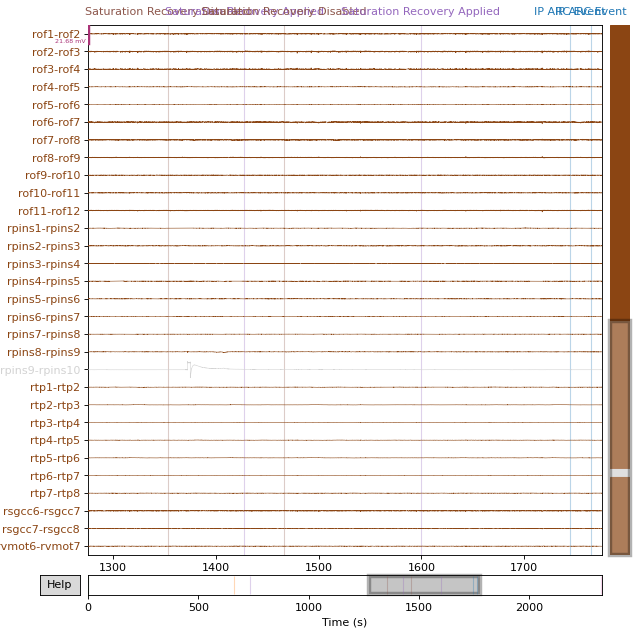

In [88]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=500, n_channels=30, scalings=mne_data_bp_reref._data.max())


Effective window size : 0.512 (s)


<IPython.core.display.Javascript object>


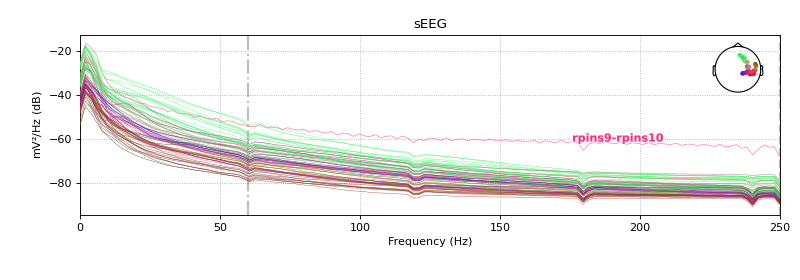

<IPython.core.display.Javascript object>


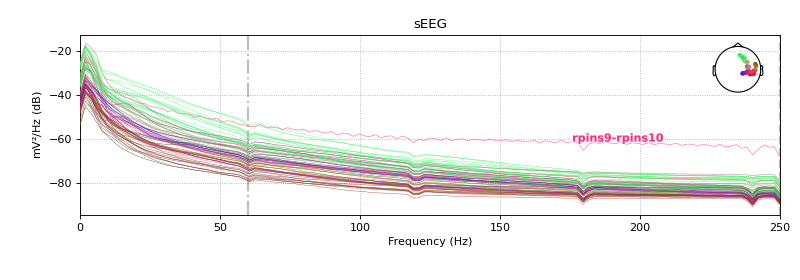

In [87]:
mne_data_bp_reref.compute_psd().plot()

In [89]:
print(mne_data_bp_reref.info['bads'],date)

['rpins9-rpins10'] 06232024


## Save Reref Data

In [90]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA039/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA039/bp_ref_ieeg.fif
[done]


In [91]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

# Photodiode Alignment
SWB photodiodes should be aligned to TrialOnset
- extract TrialOnset times to align to photodiode deflection onset 
- clean photodiode data if necessary (if photodiode is inverted, noisy etc)
- align photodiode (if function fails, try manual alignment)
- verify proper alignment by plotting

In [92]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
behav_df

Round  Trial Num TrialType   TrialOnset  ChoiceOnset  DecisionOnset  \
0        1       50.0       mix   498.672947   498.688591     501.722375   
1        2       36.0       mix   509.176416   509.196714     516.049293   
2        3       71.0      gain   523.001425   523.025433     530.975834   
3        4      147.0      loss   543.305466   543.318209     551.301954   
4        5      112.0      loss   554.101407   554.118643     558.746641   
..     ...        ...       ...          ...          ...            ...   
145    146       79.0      gain  2259.827656  2259.828749    2260.908450   
146    147       30.0       mix  2267.502359  2267.534059    2269.371331   
147    148       13.0       mix  2282.349445  2282.350662    2286.380667   
148    149       18.0       mix  2293.040983  2293.042042    2296.209186   
149    150      140.0      loss  2303.711312  2303.712405    2306.921076   

     FeedbackOnset        RT  SafeBet  LowBet  ...  totalCPE decisionCPE  \
0       501.731201  3.033783      0.0   -1.50  ...     -3.00       -3.00   
1       516.055576  6.852579      0.0   -0.30  ...      0.30        0.30   
2       532.993620  7.950401      0.4    0.00  ...      0.67        0.27   
3         0.000000  0.000000     -0.6   -1.90  ...      0.00        0.00   
4       558.756038  4.627998     -0.3   -0.55  ...      0.25        0.25   
..             ...       ...      ...     ...  ...       ...         ...   
145    2262.926195  1.079701      0.4    0.00  ...      1.68        1.28   
146    2269.377701  1.837272      0.0   -1.50  ...      1.50        1.50   
147    2286.389886  4.030006      0.0   -0.50  ...     -0.41       -0.41   
148    2296.218136  3.167144      0.0   -0.80  ...     -0.42       -0.42   
149    2308.938158  3.208672     -0.5   -2.50  ...     -2.50       -2.00   

    totalRegret decisionRegret totalRelief decisionRelief  totalCF  \
0         -3.00          -3.00        0.00           0.00     3.00   
1          0.00           0.00        0.30           0.30    -0.30   
2          0.00           0.00        0.67           0.27     0.00   
3          0.00           0.00        0.00           0.00     0.00   
4          0.00           0.00        0.25           0.25    -0.55   
..          ...            ...         ...            ...      ...   
145        0.00           0.00        1.68           1.28     0.00   
146        0.00           0.00        1.50           1.50    -1.50   
147       -0.41          -0.41        0.00           0.00     0.41   
148       -0.42          -0.42        0.00           0.00     0.42   
149       -2.50          -2.00        0.00           0.00     0.00   

     decisionCF   pRPE  nRPE  
0          3.00  0.000  0.00  
1         -0.30  0.000  0.00  
2          0.40  0.335  0.00  
3          0.00  0.000  0.00  
4         -0.55  0.000  0.00  
..          ...    ...   ...  
145        0.40  0.840  0.00  
146       -1.50  0.000  0.00  
147        0.41  0.000  0.00  
148        0.42  0.000  0.00  
149       -0.50  0.000 -1.25  

[150 rows x 32 columns]

In [93]:
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA039/photodiode.fif...
Isotrak not found
    Range : 0 ... 1165061 =      0.000 ...  2330.122 secs
Ready.
Reading 0 ... 1165061  =      0.000 ...  2330.122 secs...


In [94]:
photodiode_data

<Raw | photodiode.fif, 1 x 1165062 (2330.1 s), ~8.9 MB, data loaded>

<IPython.core.display.Javascript object>


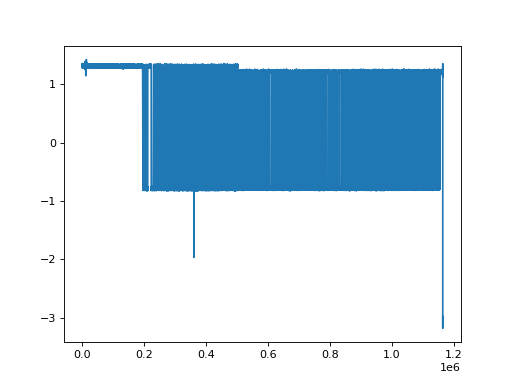

In [96]:
plt.plot(zscore(photodiode_data._data[0,:]))
# plt.xlim([600000,700000])
plt.show()


In [97]:
temp_diode = photodiode_data.copy()
temp_diode._data = np.negative(temp_diode._data)
# temp_diode._data[temp_diode._data>-0.045] = np.min(temp_diode._data)

<IPython.core.display.Javascript object>


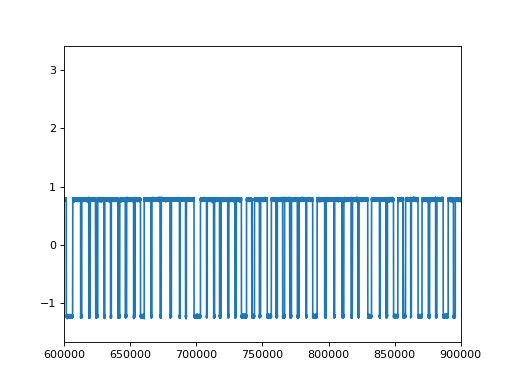

In [99]:
plt.plot(zscore(temp_diode._data[0,:]))
plt.xlim([600000,900000])
# plt.ylim([-0.045,0])
plt.show()


In [100]:
### Photodiode alignment
smoothSize=11
windSize=15
height=0.7


# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            temp_diode, #
                                            smoothSize, windSize, height)

10 blocks
..........

found matches for 120 of 157 pulses


In [101]:
print(slope, offset,smoothSize,windSize,height)

0.9999989961244944 -3.3446912955898824 11 15 0.7


In [102]:
# calculate pulse times from slope + offset
pulses = [(x*slope + offset) for x in beh_ts]
len(pulses) 

150

In [103]:
##### validate by plotting!
photo_sfreq = photodiode_data.info['sfreq']
photo_sfreq


500.0

<IPython.core.display.Javascript object>


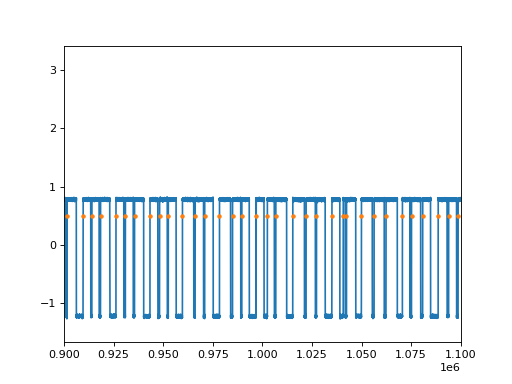

In [104]:
plt.plot(scipy.stats.zscore(-photodiode_data._data[0,:]))
plt.plot(np.array(pulses)*photo_sfreq, 
         np.ones_like(np.array(pulses)*photo_sfreq)-0.5, '.')

plt.xlim([900000,1100000])
# plt.xlim([500000,700000])
plt.show()

# Epoch Data
- Epoch neural data into trial epochs (and save df with IEDs/artifacts for every ev)
- Save epochs
- Baseline + decompose data into TFRs
- Add behavioral data to epochs metadata
- Plot + save TFRs (examine quality)

Note: Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated


In [ ]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

### Get behavior ts for epochs of interest
- time points in SWB code are nonsensical - choice onset is a repeat of trial onset, and the difference between choice onset and decision onset is just the RT.
- even worse, feedback onset does not accurately mark feedback for safe choice trials - the feedback time is the safe outcome reveal, NOT counterfactual feedback. There is no true counterfactual feedback timestamp that's accurate for every trial. 
- Solution - make a new timestamp vector that is +2 seconds after DecisionOnset to use for counterfactual outcome feedback epochs


MAJOR UPDATE 05/09/2024 FROM PIPELINE UPDATE

In [105]:
#### load behavior data and define baseline/analysis epoch timepoints 

#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
behav_df

Round  Trial Num TrialType   TrialOnset  ChoiceOnset  DecisionOnset  \
0        1       50.0       mix   498.672947   498.688591     501.722375   
1        2       36.0       mix   509.176416   509.196714     516.049293   
2        3       71.0      gain   523.001425   523.025433     530.975834   
3        4      147.0      loss   543.305466   543.318209     551.301954   
4        5      112.0      loss   554.101407   554.118643     558.746641   
..     ...        ...       ...          ...          ...            ...   
145    146       79.0      gain  2259.827656  2259.828749    2260.908450   
146    147       30.0       mix  2267.502359  2267.534059    2269.371331   
147    148       13.0       mix  2282.349445  2282.350662    2286.380667   
148    149       18.0       mix  2293.040983  2293.042042    2296.209186   
149    150      140.0      loss  2303.711312  2303.712405    2306.921076   

     FeedbackOnset        RT  SafeBet  LowBet  ...  totalCPE decisionCPE  \
0       501.731201  3.033783      0.0   -1.50  ...     -3.00       -3.00   
1       516.055576  6.852579      0.0   -0.30  ...      0.30        0.30   
2       532.993620  7.950401      0.4    0.00  ...      0.67        0.27   
3         0.000000  0.000000     -0.6   -1.90  ...      0.00        0.00   
4       558.756038  4.627998     -0.3   -0.55  ...      0.25        0.25   
..             ...       ...      ...     ...  ...       ...         ...   
145    2262.926195  1.079701      0.4    0.00  ...      1.68        1.28   
146    2269.377701  1.837272      0.0   -1.50  ...      1.50        1.50   
147    2286.389886  4.030006      0.0   -0.50  ...     -0.41       -0.41   
148    2296.218136  3.167144      0.0   -0.80  ...     -0.42       -0.42   
149    2308.938158  3.208672     -0.5   -2.50  ...     -2.50       -2.00   

    totalRegret decisionRegret totalRelief decisionRelief  totalCF  \
0         -3.00          -3.00        0.00           0.00     3.00   
1          0.00           0.00        0.30           0.30    -0.30   
2          0.00           0.00        0.67           0.27     0.00   
3          0.00           0.00        0.00           0.00     0.00   
4          0.00           0.00        0.25           0.25    -0.55   
..          ...            ...         ...            ...      ...   
145        0.00           0.00        1.68           1.28     0.00   
146        0.00           0.00        1.50           1.50    -1.50   
147       -0.41          -0.41        0.00           0.00     0.41   
148       -0.42          -0.42        0.00           0.00     0.42   
149       -2.50          -2.00        0.00           0.00     0.00   

     decisionCF   pRPE  nRPE  
0          3.00  0.000  0.00  
1         -0.30  0.000  0.00  
2          0.40  0.335  0.00  
3          0.00  0.000  0.00  
4         -0.55  0.000  0.00  
..          ...    ...   ...  
145        0.40  0.840  0.00  
146       -1.50  0.000  0.00  
147        0.41  0.000  0.00  
148        0.42  0.000  0.00  
149       -0.50  0.000 -1.25  

[150 rows x 32 columns]

In [106]:
list(zip(behav_df.GambleChoice,behav_df.DecisionOnset,behav_df.FeedbackOnset))

[('safe', 501.722374532721, 501.7312014112249),
 ('safe', 516.0492933036294, 516.0555762252188),
 ('gamble', 530.9758339455002, 532.9936204811092),
 ('gamble', 551.3019539964735, 0.0),
 ('safe', 558.7466412805952, 558.756037844345),
 ('gamble', 569.3921417570673, 571.4086247409577),
 ('safe', 582.269623250002, 582.2759590782807),
 ('gamble', 591.3651300070342, 593.3836596251931),
 ('safe', 601.2942675124505, 601.3033828175976),
 ('safe', 620.8530341797741, 0.0),
 ('gamble', 625.8164517860278, 627.8332211484667),
 ('gamble', 637.427893004322, 639.4446982067893),
 ('safe', 652.2878739988664, 652.2969708719756),
 ('gamble', 661.0671757538803, 663.0840256710071),
 ('gamble', 672.0452256349381, 674.0620267414488),
 ('gamble', 682.2408526095678, 684.2575775987352),
 ('gamble', 692.3194179721759, 694.3368949185242),
 ('gamble', 705.6303876044112, 707.6473191002151),
 ('safe', 716.6083617095137, 716.6172565133311),
 ('gamble', 728.1200820701779, 730.1372200726182),
 ('gamble', 739.048132770462

In [107]:
behav_df['CpeOnset'] = behav_df.DecisionOnset + 2.0
behav_df['CpeOnset']

0       503.722375
1       518.049293
2       532.975834
3       553.301954
4       560.746641
          ...     
145    2262.908450
146    2271.371331
147    2288.380667
148    2298.209186
149    2308.921076
Name: CpeOnset, Length: 150, dtype: float64

## SWB Epochs:

**Baseline epoch** = 1 sec prior to trial onset \
**Decision epoch** = 0.5 sec prior to decision onset (choice epoch) \
**Feedback epoch** = 3 sec after CPE reveal \

*Outputs: Raw epoched data & IED + artifact dfs for every epoch*


In [108]:
# Define epochs of interest according to timestamps from behavior df 

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [-0.5, 0], # 0.5 sec prior to choice
       'CpeOnset': [0,3.0] } # 3 sec following CPE outcome reveal - timestamps are made manually above

In [109]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [110]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [111]:
### make epochs should now find IEDs, artifact times, and save info as df in load_path directory for every ev

for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                                                 slope=slope, offset=offset,
                                                 behav_name=event, behav_times=behav_df[event].values,
                                                 ev_start_s=evs[event][0], ev_end_s=evs[event][1],
                                                 buf_s = 1, IED_args=IED_args,
                                                 downsamp_factor=None,  
                                                 detrend=0) #### new - constant detrend by DC offset https://mne.tools/stable/generated/mne.Epochs.html

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA039/bp_ref_ieeg.fif...
    Range : 0 ... 1165061 =      0.000 ...  2330.122 secs
Ready.
Reading 0 ... 1165061  =      0.000 ...  2330.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  68 out of  68 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  68 out of  68 | elapsed:    9.8s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA039/bp_ref_ieeg.fif...
    Range : 0 ... 1165061 =      0.000 ...  2330.122 secs
Ready.
Reading 0 ... 1165061  =      0.000 ...  2330.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  68 out of  68 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  68 out of  68 | elapsed:    9.0s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1251 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA039/bp_ref_ieeg.fif...
    Range : 0 ... 1165061 =      0.000 ...  2330.122 secs
Ready.
Reading 0 ... 1165061  =      0.000 ...  2330.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  68 out of  68 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  68 out of  68 | elapsed:    9.2s finished


Used Annotations descriptions: ['CpeOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 2501 original time points ...
0 bad epochs dropped


In [113]:
epochs_all_evs 


{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~116.9 MB, data loaded,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1.5 - 1 sec, baseline off, ~97.5 MB, data loaded,
  'DecisionOnset': 150>,
 'CpeOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~194.8 MB, data loaded,
  'CpeOnset': 150>}

In [114]:
# to plot epochs if desired 
# %matplotlib notebook
# fig = epochs_all_subjs_all_evs['MS007']['feedback_start'].plot(n_epochs=10, n_channels=10)

# # Need this following line to save the annotations to the epochs object 
# fig.fake_keypress('a')

### Add behavioral data to metadata

In [115]:
behav_params = ['Round','RT','CpeOnset','GambleChoice','TrialType',
                'SafeBet', 'LowBet', 'HighBet', 'GambleEV','Outcome',
                'Profit', 'TotalProfit', 'CR', 'choiceEV', 'RPE',
                'decisionCPE', 'decisionRegret','decisionRelief', 'decisionCF']

In [116]:
for event in evs.keys():

    event_metadata = pd.DataFrame(columns=behav_params)
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Adding metadata with 19 columns
Adding metadata with 19 columns
Adding metadata with 19 columns


### Save raw epoched data 

In [117]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/{event}_epochs.fif', overwrite=True)

In [118]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~116.9 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1.5 - 1 sec, baseline off, ~97.5 MB, data loaded, with metadata,
  'DecisionOnset': 150>,
 'CpeOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~194.8 MB, data loaded, with metadata,
  'CpeOnset': 150>}

# Compute Baseline + Analysis TFRs
*Major updates 05/09/2024*
- Instead of removing entire epochs with IEDs, removing +/-100ms of IED or artifact timepoint 
- Now we have two analysis evs of interest - pre-decision epoch and cpe outcome epoch

In [119]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict

baseline_ev  = 'TrialOnset' # fixation cross baseline epoch
analysis_evs = ['DecisionOnset','CpeOnset']

# dictionary of event ids and times - repeated from above
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [-0.5, 0], # 0.5 sec prior to choice
       'CpeOnset': [0,3.0] } # 3 sec following CPE outcome reveal - timestamps are made manually above

In [120]:
# Define spectrogram parameters for morlet wavelets 

freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))


### Make Baseline TFR Epochs 

In [121]:
#### COMPUTE BASELINE TFRs 

# baseline epoch dictionary 
epochs_all_baseline = {} 

# baseline event = TrialOnset epochs 
baseline_epochs_reref = epochs_all_evs[baseline_ev]

# dropping bad channels from baseline epochs 
baseline_epochs_reref = baseline_epochs_reref.drop_channels(baseline_epochs_reref.info['bads'])

# compute baseline tfr 
temp_pow  = mne.time_frequency.tfr_morlet(baseline_epochs_reref, freqs=freqs, n_cycles=n_cycles, 
                                          picks=baseline_epochs_reref.ch_names, # now doesn't include bad ch
                                          use_fft=True, n_jobs=-1, output='power',
                                          return_itc=False, average=False) # returns pow (not ITC) for all epochs

temp_pow.crop(tmin=evs[baseline_ev][0], tmax=evs[baseline_ev][1]) # clipping epoch to remove buffer

# Remove bad data by naning out +/-100ms around bad timepoints (IEDs and artifacts)
# THE following will now LOAD in dataframes that indicate IED and artifact time points in your data
IED_df = pd.read_csv(f'{neural_dir}{subj_id}/{baseline_ev}_IED_df.csv') 
artifact_df = pd.read_csv(f'{neural_dir}{subj_id}/{baseline_ev}_artifact_df.csv') 

# iterate through each channel, IED/artifact & nan tfr data +/-100ms from IED/artifact
for ch_ix, ch_name in enumerate(baseline_epochs_reref.ch_names):
    # lists of IED/artifact timestamps from dfs for one channel (if any)
    ied_ev_list = IED_df[ch_name].dropna().index.tolist()
    artifact_ev_list = artifact_df[ch_name].dropna().index.tolist()
    
    # iterate through every IED timestamp in channel 
    for ev_ in ied_ev_list: 
        # iterate through values in IED df (literal eval = evaluates string as literal python data structures)
        for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((ied_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after 
            ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
    
    # iterate through every artifact timestamp in channel 
    for ev_ in artifact_ev_list: 
         # iterate through values in artifact df (literal eval = evaluates string as literal python data structures)
        for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after
            ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan

epochs_all_baseline[baseline_ev] = temp_pow


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:   23.9s finished


Adding metadata with 19 columns


In [122]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 67, ~1.13 GB>}

### Compute Baseline-corrected TFRs for Analysis Epochs

In [123]:
#### COMPUTE ANALYSIS EVENT TFRs + BASELINE TO BASELINE TFRs 

# repeat baselining procedure for every event in analysis_evs
# remove +/-100ms around IED/artifact individually for each analysis epoch 
# baseline analysis ev tfrs
# iteratively check for zscores still above 10 std, remove those timepoints, then recompute baselined tfr


power_epochs = {} # keys = analysis evs 

for event in analysis_evs: 
    print('Compute baselined TFR for epoch: ',event)
    
    # extract raw epoch data for analysis ev 
    event_epochs_reref = epochs_all_evs[event].copy()
    # dropping bad channels from baseline epochs 
    event_epochs_reref = event_epochs_reref.drop_channels(event_epochs_reref.info['bads'])
    ch_names = event_epochs_reref.ch_names
    
    # compute TFR from raw epoched data
    temp_pow = mne.time_frequency.tfr_morlet(event_epochs_reref, freqs=freqs, n_cycles=n_cycles, 
                                             picks=event_epochs_reref.ch_names, 
                                             use_fft=True, n_jobs=-1, output='power', 
                                             return_itc=False, average=False)
    # crop 1.0 sec buffer from analysis epoch 
    temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])
    
    ### repeat IED/artifact removal procedure used for baseline epochs, but with analysis event IED/artifact times
    
    # load IED/artifact dfs specific to event in analysis evs
    IED_df = pd.read_csv(f'{neural_dir}{subj_id}/{event}_IED_df.csv') 
    artifact_df = pd.read_csv(f'{neural_dir}{subj_id}/{event}_artifact_df.csv') 
    
    # iterate through each channel, IED/artifact & nan tfr data +/-100ms from IED/artifact
    for ch_ix, ch_name in enumerate(event_epochs_reref.ch_names): 
        ied_ev_list = IED_df[ch_name].dropna().index.tolist()
        artifact_ev_list = artifact_df[ch_name].dropna().index.tolist() 
        for ev_ in ied_ev_list: 
            for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((ied_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
        for ev_ in artifact_ev_list: 
            for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan

    ##### remove extreme power values (z>10) remaining after IED/artifact removal 
    # iterative process - baseline correct event TFR, remove z > 10, re-baseline until no z>10 or reached max iters
    
                
    # Let's nan out absurd z-scores (10 std above baseline???) that escaped our artifact detection, noise removal, and baselining
    absurdity_threshold = 10 # zscore threshold for removal
    max_iter = 10 # max number of iterations for while loop 
    large_z_flag=True # flag that indicates whether large zs are present, when all z<10 = False in while loop

    iteration = 0 # intialize iter counter
    while (large_z_flag==True) & (iteration<max_iter): # while z>10 still in tfr or under max iter num 
        print(f'baseline z-score iteration # {iteration}')
        # Baseline by all the baseline periods in the session
        baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                              baseline_mne=epochs_all_baseline[baseline_ev].data,  
                              mode='zscore', ev_axis=0, elec_axis=1, freq_axis=2, time_axis=3)

        large_z_mask = np.where(baseline_corrected_power>absurdity_threshold)
        if large_z_mask[0].shape[0] == 0:
            # no more large z
            large_z_flag = False
        else:
            # NaN it out in the event of interest prior to re-running the baseline z-score to prevent
            # contamination of all z's
            temp_pow.data[large_z_mask] = np.nan

        iteration +=1
    
    # input baseline corrected pow into mne EpochsTFR object once all z>10 removed or iteratively removed 10x 
    zpow = mne.time_frequency.EpochsTFR(event_epochs_reref.info, baseline_corrected_power,
                                        temp_pow.times, freqs)
    
    # add metadata to baseline corrected TFR event epochs object 
    zpow.metadata = event_epochs_reref.metadata
    
    # save data (#conda install -c conda-forge h5io must install to save tfr data)
    zpow.save(f'{neural_dir}{subj_id}/{subj_id}_{event}-tfr.h5', overwrite=True) 
    
    # store event zpow epochs in dict for all analysis evs 
    power_epochs[event] = zpow
    

Compute baselined TFR for epoch:  DecisionOnset


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:   18.6s finished


Adding metadata with 19 columns
baseline z-score iteration # 0
baseline z-score iteration # 1
baseline z-score iteration # 2
baseline z-score iteration # 3
baseline z-score iteration # 4
baseline z-score iteration # 5
baseline z-score iteration # 6
Not setting metadata
Adding metadata with 19 columns
Compute baselined TFR for epoch:  CpeOnset


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:   35.6s finished


Adding metadata with 19 columns
baseline z-score iteration # 0
baseline z-score iteration # 1
baseline z-score iteration # 2
baseline z-score iteration # 3
baseline z-score iteration # 4
baseline z-score iteration # 5
baseline z-score iteration # 6
baseline z-score iteration # 7
baseline z-score iteration # 8
Not setting metadata
Adding metadata with 19 columns


In [124]:
power_epochs

{'DecisionOnset': <EpochsTFR | time : [-0.500000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 67, ~577.5 MB>,
 'CpeOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 67, ~3.37 GB>}

In [125]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [-0.500000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 67, ~577.5 MB>

In [126]:
power_epochs['CpeOnset']

<EpochsTFR | time : [0.000000, 3.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 67, ~3.37 GB>

# Plot TFRs 
- For each analysis event, plot the mean TFR across all epochs for all channels
- Save plots
- Visually inspect TFRs to see if further data cleaning is necessary

In [127]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/single_elec_tfrs/{subj_id}/'

# print date of TFR plotting 
date = datetime.date.today().strftime('%m%d%Y')
print(date, offset) # print date, double check current slope/offset


06242024 -3.3446912955898824


Plot TFR for epoch:  DecisionOnset


<IPython.core.display.Javascript object>


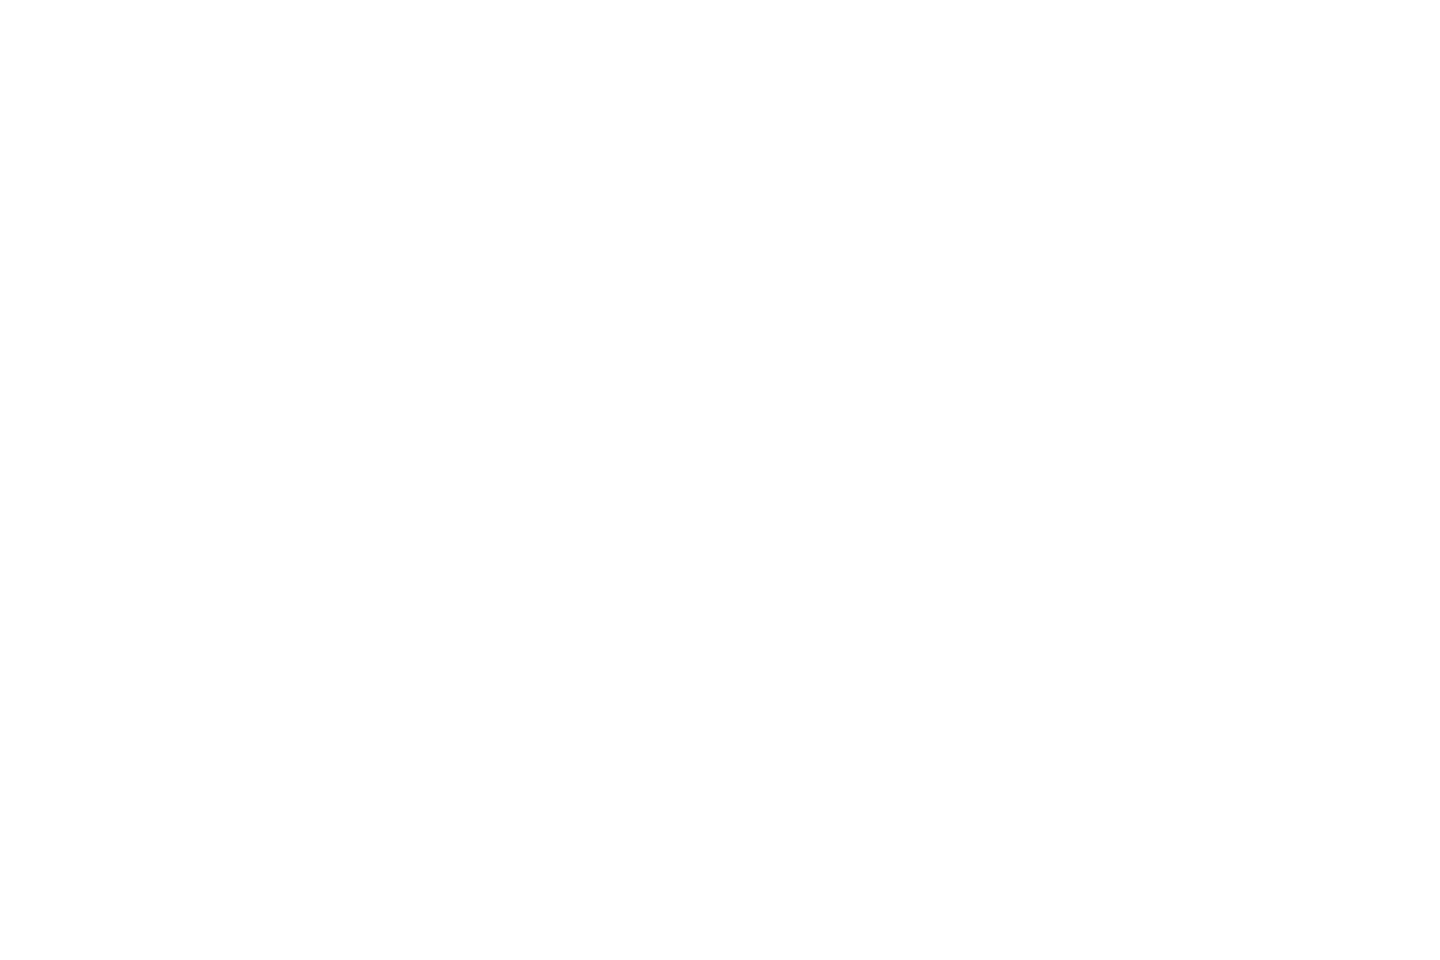

<IPython.core.display.Javascript object>


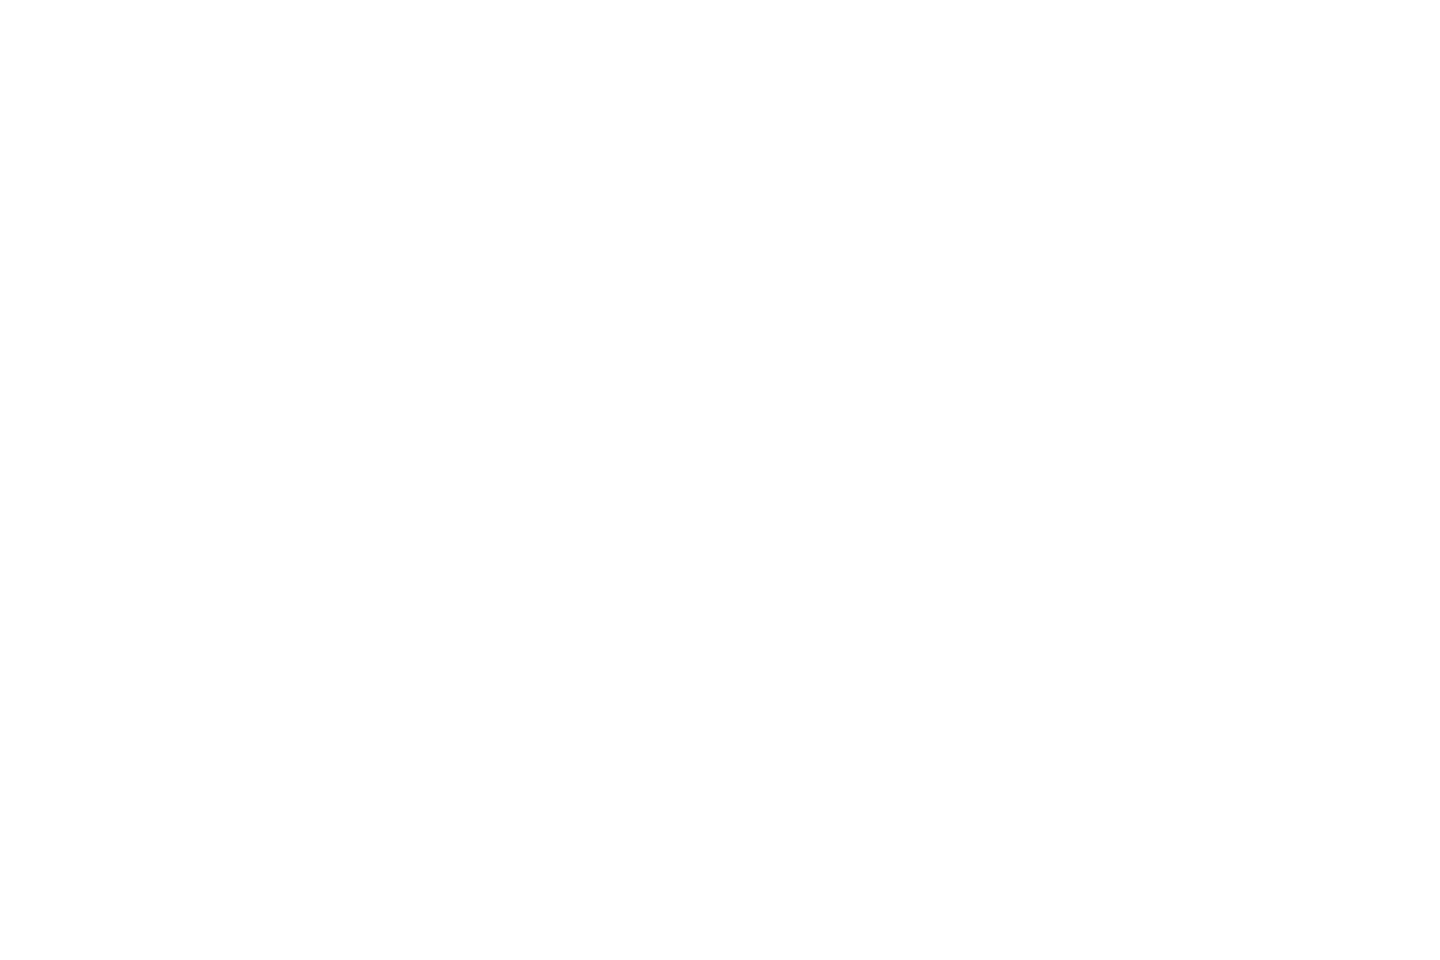

<IPython.core.display.Javascript object>


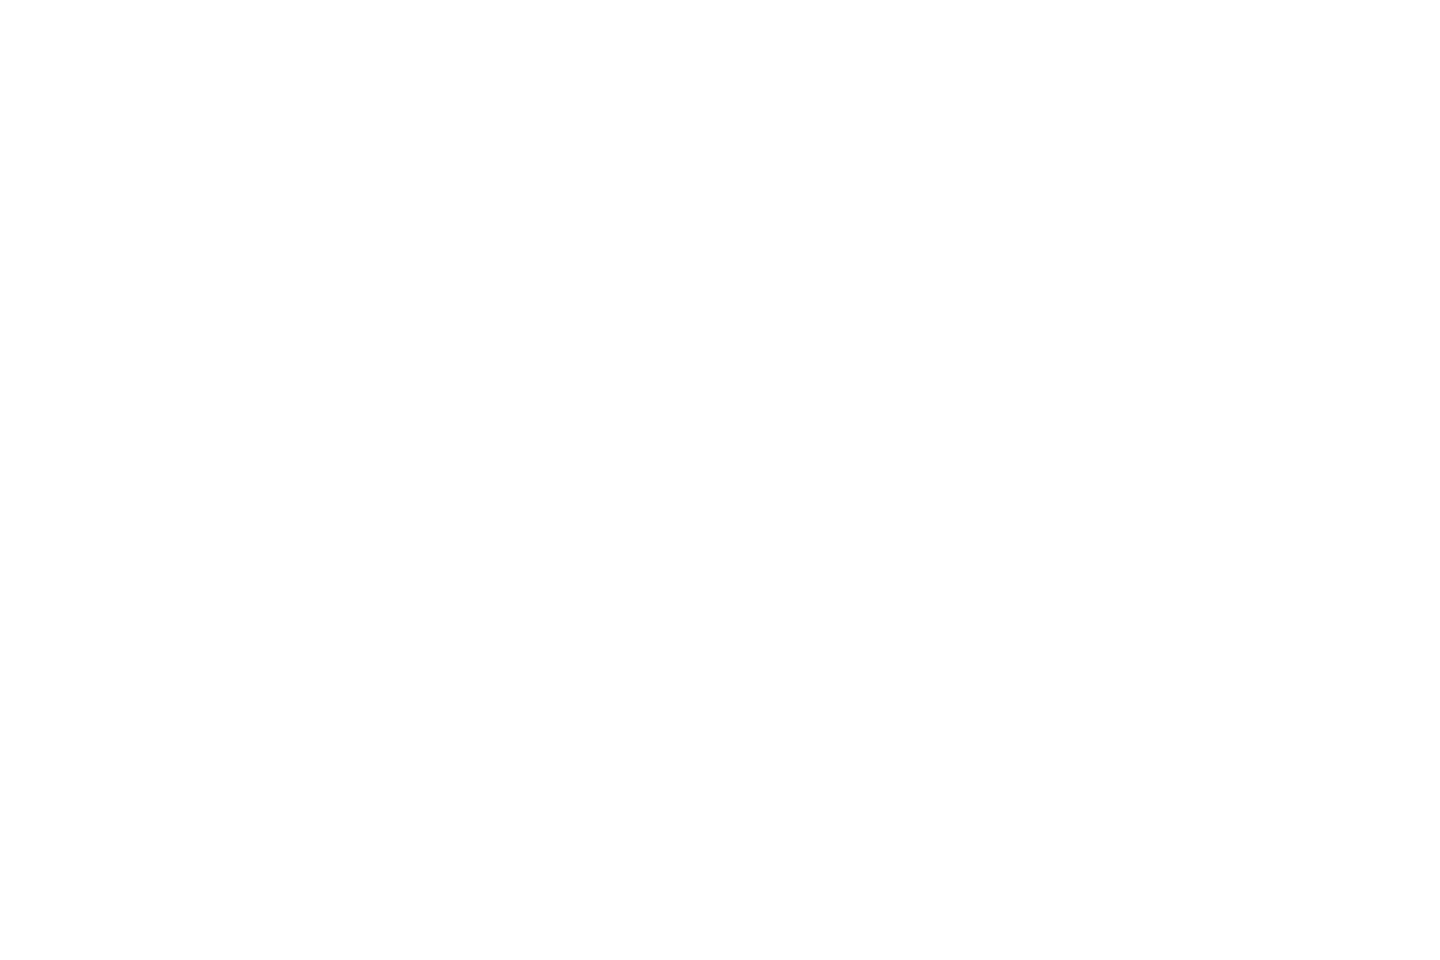

<IPython.core.display.Javascript object>


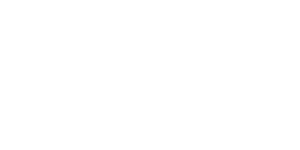

<IPython.core.display.Javascript object>


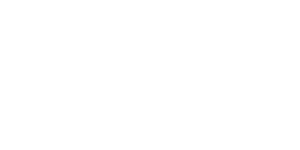

<IPython.core.display.Javascript object>


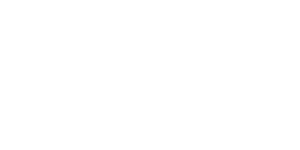

<IPython.core.display.Javascript object>


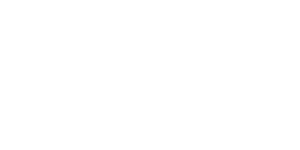

<IPython.core.display.Javascript object>


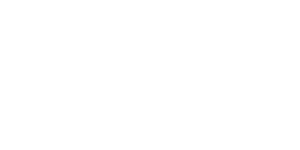

<IPython.core.display.Javascript object>


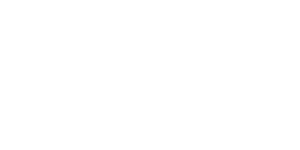

<IPython.core.display.Javascript object>


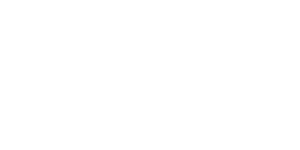

<IPython.core.display.Javascript object>


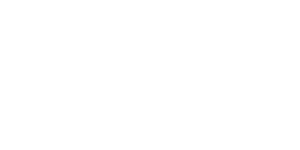

<IPython.core.display.Javascript object>


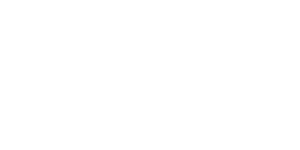

<IPython.core.display.Javascript object>


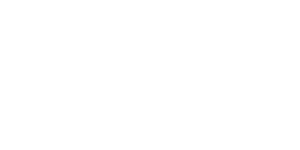

<IPython.core.display.Javascript object>


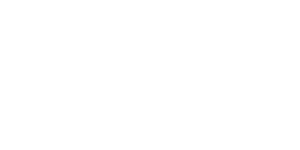

<IPython.core.display.Javascript object>


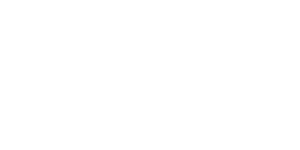

<IPython.core.display.Javascript object>


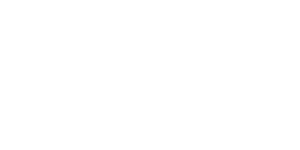

<IPython.core.display.Javascript object>


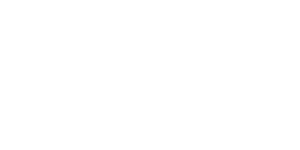

<IPython.core.display.Javascript object>


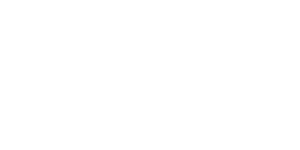

<IPython.core.display.Javascript object>


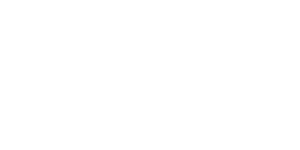

<IPython.core.display.Javascript object>


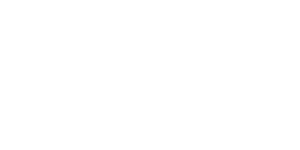

<IPython.core.display.Javascript object>


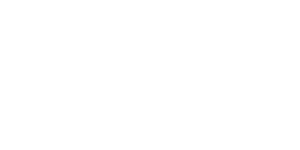

<IPython.core.display.Javascript object>


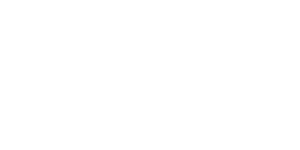

<IPython.core.display.Javascript object>


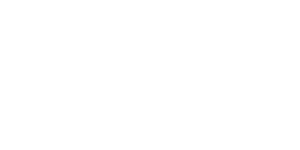

<IPython.core.display.Javascript object>


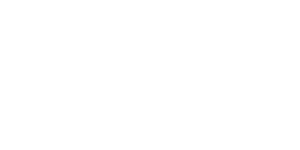

<IPython.core.display.Javascript object>


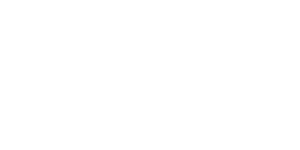

<IPython.core.display.Javascript object>


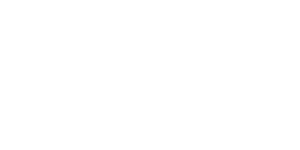

<IPython.core.display.Javascript object>


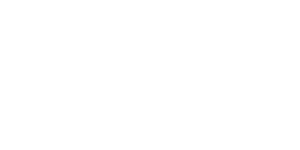

<IPython.core.display.Javascript object>


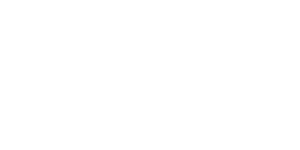

<IPython.core.display.Javascript object>


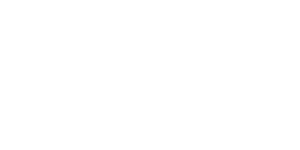

<IPython.core.display.Javascript object>


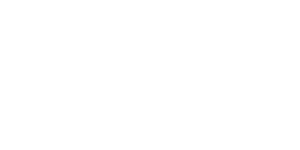

<IPython.core.display.Javascript object>


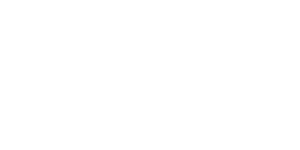

<IPython.core.display.Javascript object>


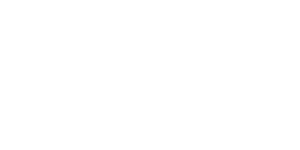

<IPython.core.display.Javascript object>


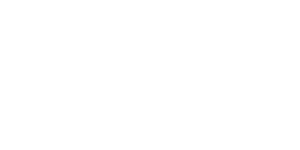

<IPython.core.display.Javascript object>


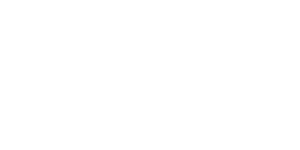

<IPython.core.display.Javascript object>


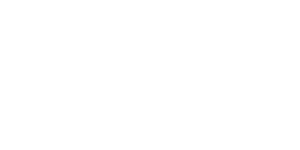

<IPython.core.display.Javascript object>


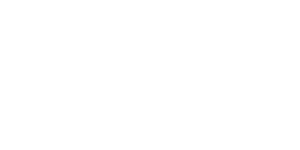

<IPython.core.display.Javascript object>


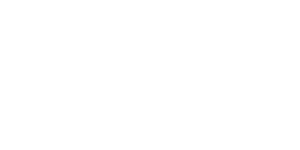

<IPython.core.display.Javascript object>


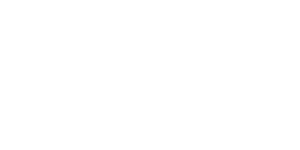

<IPython.core.display.Javascript object>


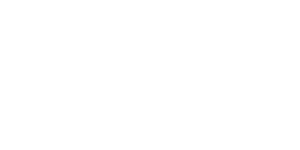

<IPython.core.display.Javascript object>


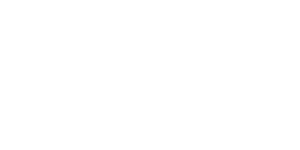

<IPython.core.display.Javascript object>


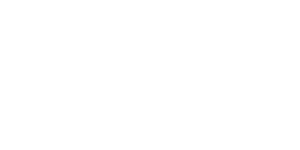

<IPython.core.display.Javascript object>


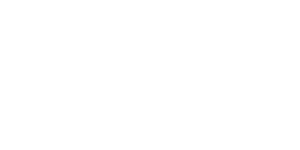

<IPython.core.display.Javascript object>


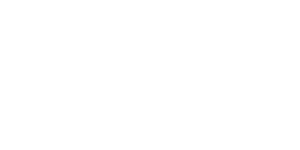

<IPython.core.display.Javascript object>


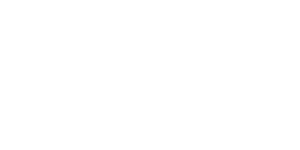

<IPython.core.display.Javascript object>


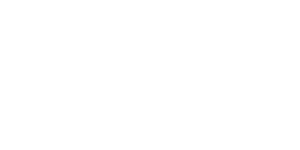

<IPython.core.display.Javascript object>


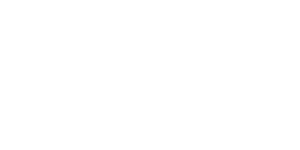

<IPython.core.display.Javascript object>


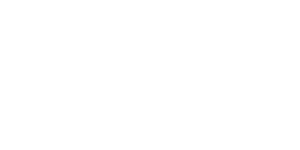

<IPython.core.display.Javascript object>


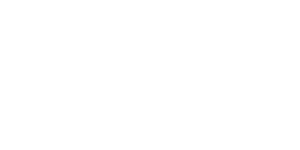

<IPython.core.display.Javascript object>


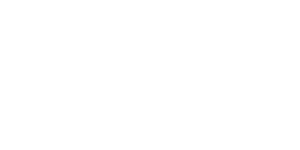

<IPython.core.display.Javascript object>


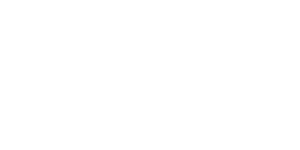

<IPython.core.display.Javascript object>


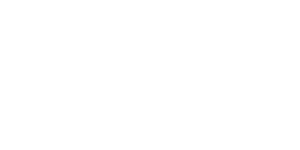

<IPython.core.display.Javascript object>


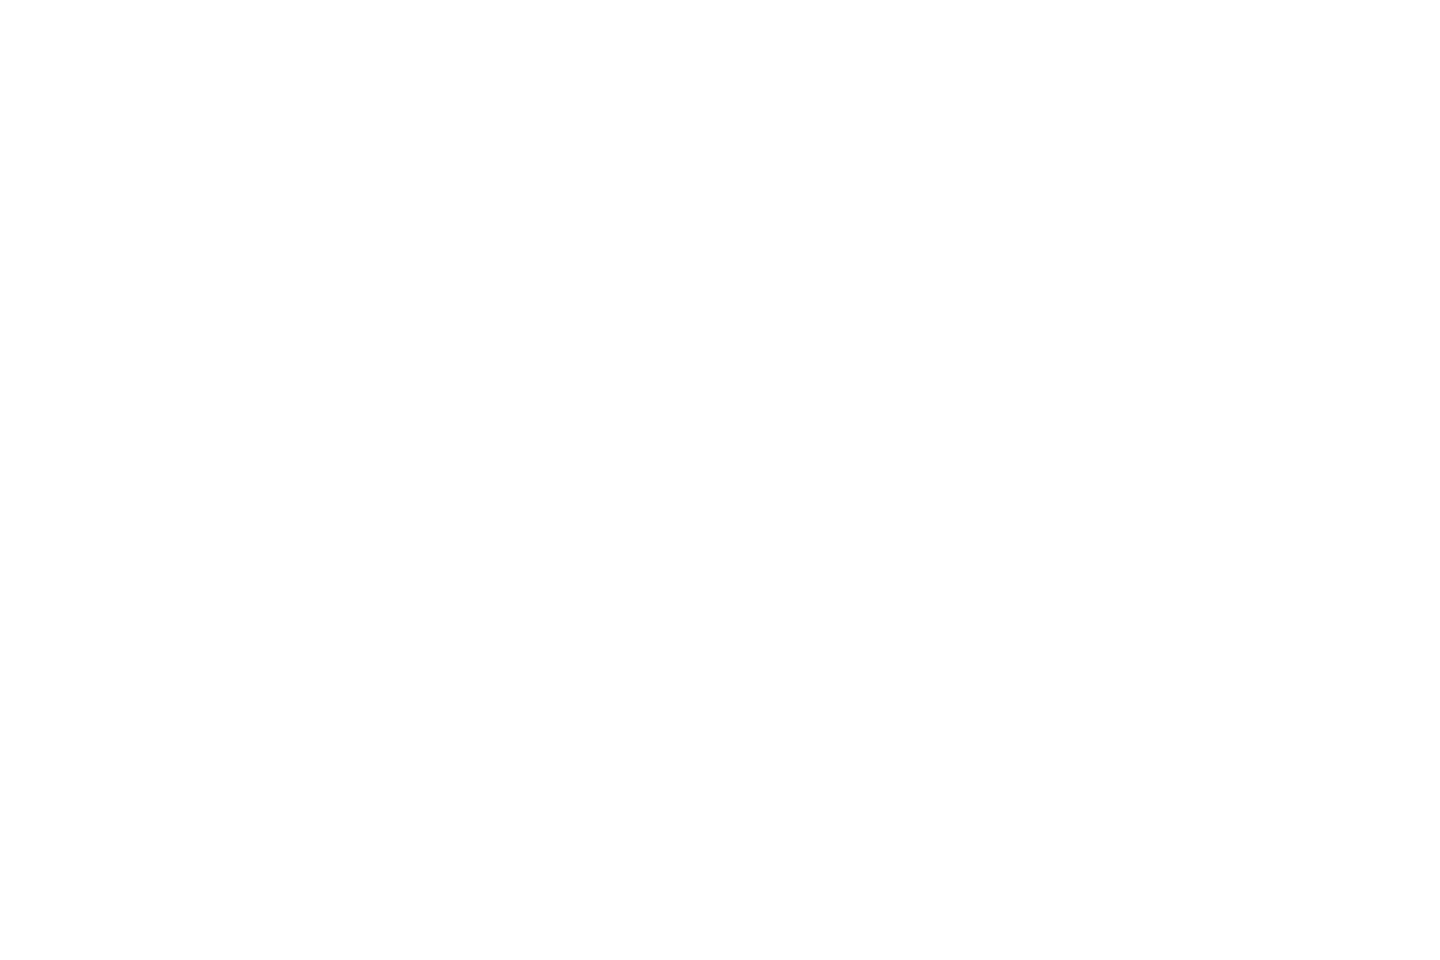

<IPython.core.display.Javascript object>


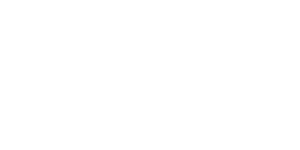

<IPython.core.display.Javascript object>


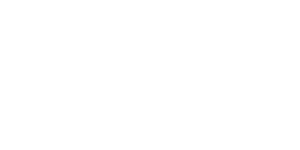

<IPython.core.display.Javascript object>


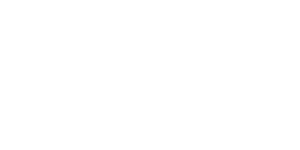

<IPython.core.display.Javascript object>


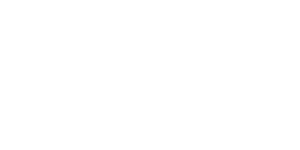

<IPython.core.display.Javascript object>


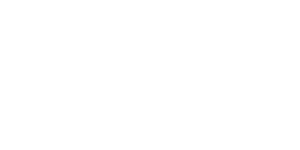

<IPython.core.display.Javascript object>


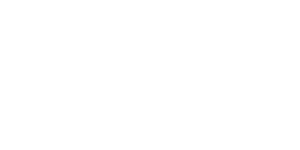

<IPython.core.display.Javascript object>


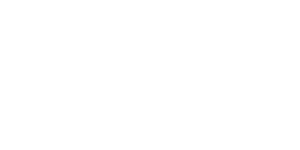

<IPython.core.display.Javascript object>


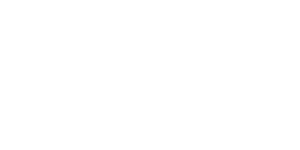

<IPython.core.display.Javascript object>


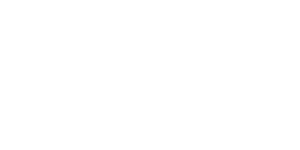

<IPython.core.display.Javascript object>


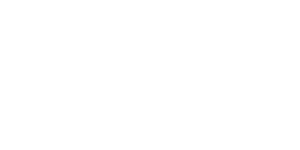

<IPython.core.display.Javascript object>


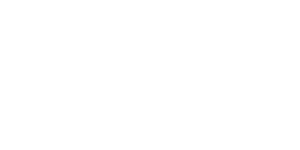

<IPython.core.display.Javascript object>


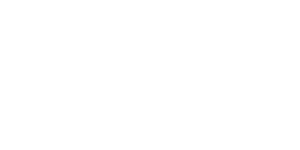

<IPython.core.display.Javascript object>


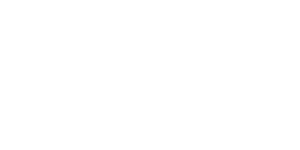

<IPython.core.display.Javascript object>


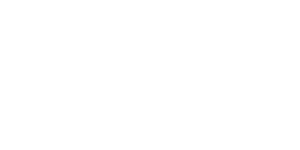

<IPython.core.display.Javascript object>


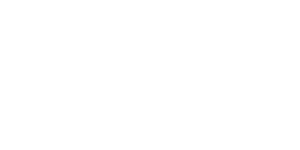

Plot TFR for epoch:  CpeOnset


<IPython.core.display.Javascript object>


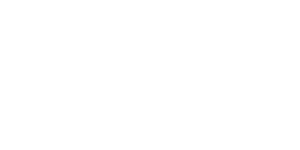

<IPython.core.display.Javascript object>


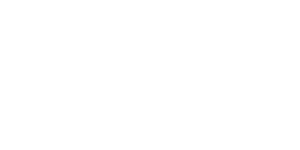

<IPython.core.display.Javascript object>


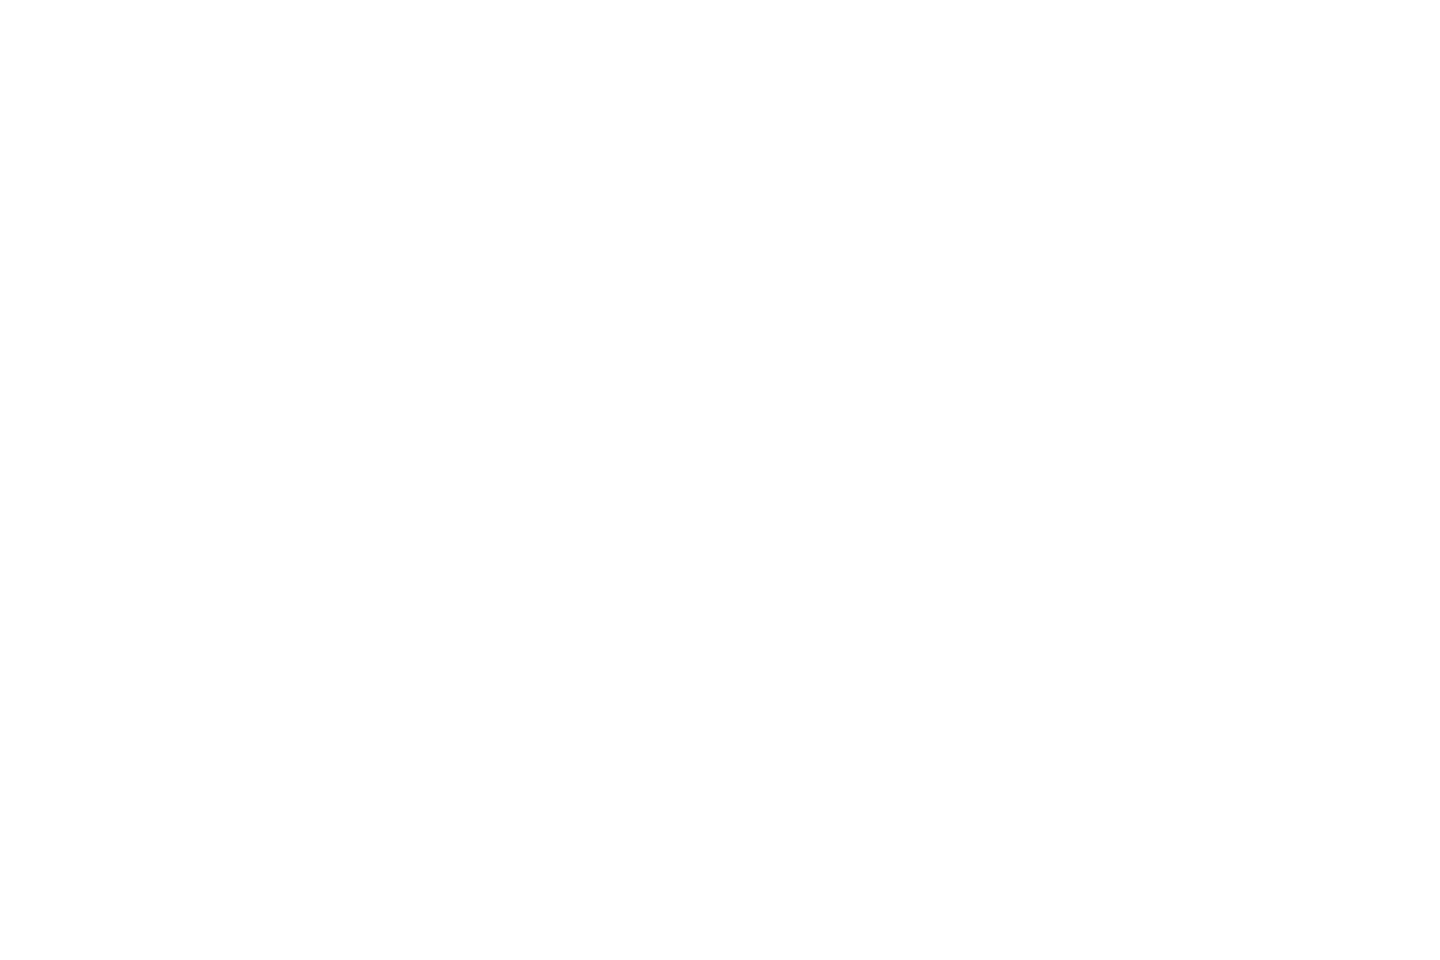

<IPython.core.display.Javascript object>


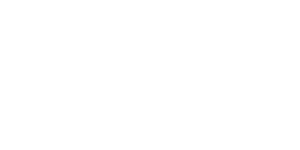

<IPython.core.display.Javascript object>


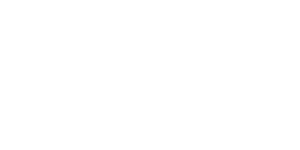

<IPython.core.display.Javascript object>


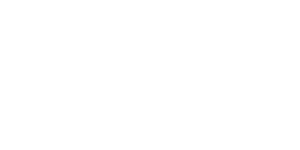

<IPython.core.display.Javascript object>


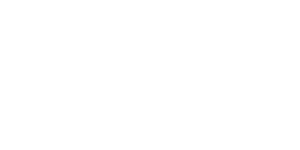

<IPython.core.display.Javascript object>


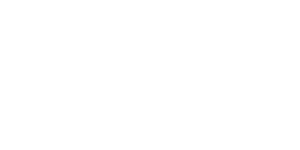

<IPython.core.display.Javascript object>


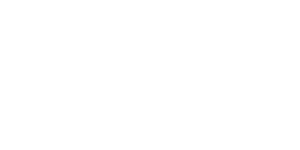

<IPython.core.display.Javascript object>


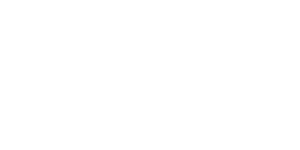

<IPython.core.display.Javascript object>


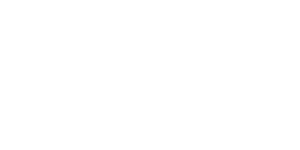

<IPython.core.display.Javascript object>


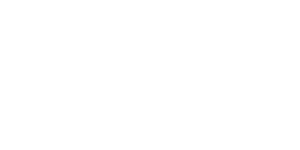

<IPython.core.display.Javascript object>


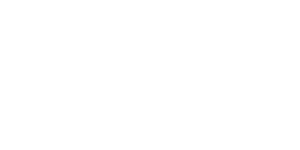

<IPython.core.display.Javascript object>


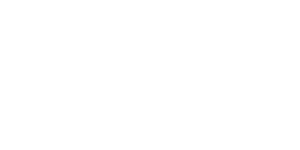

<IPython.core.display.Javascript object>


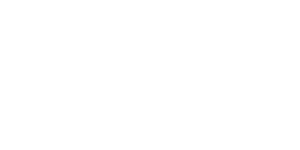

<IPython.core.display.Javascript object>


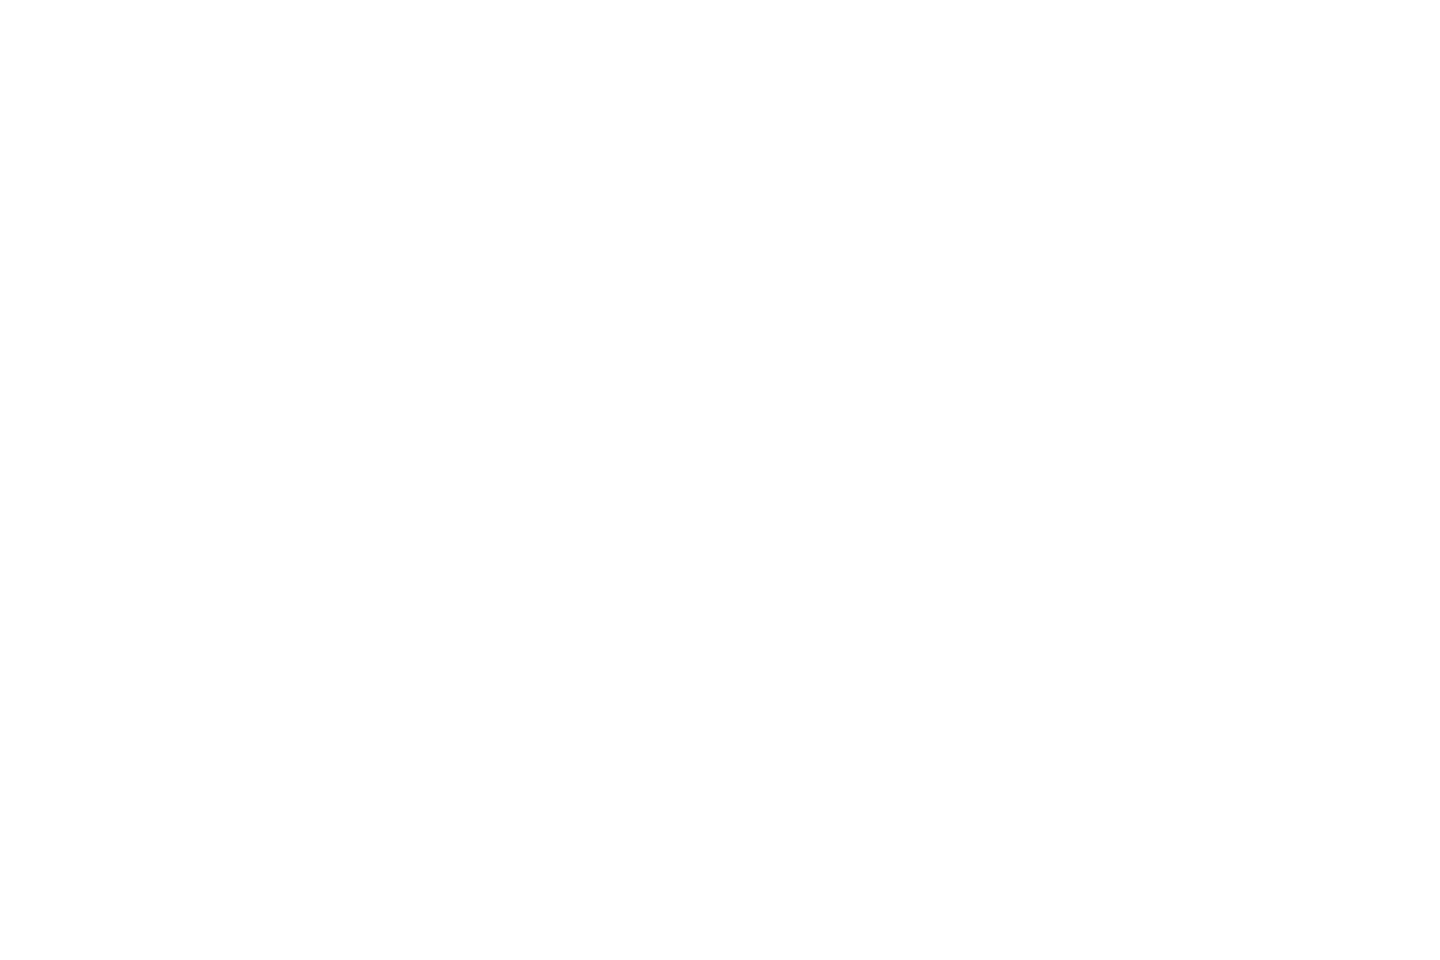

<IPython.core.display.Javascript object>


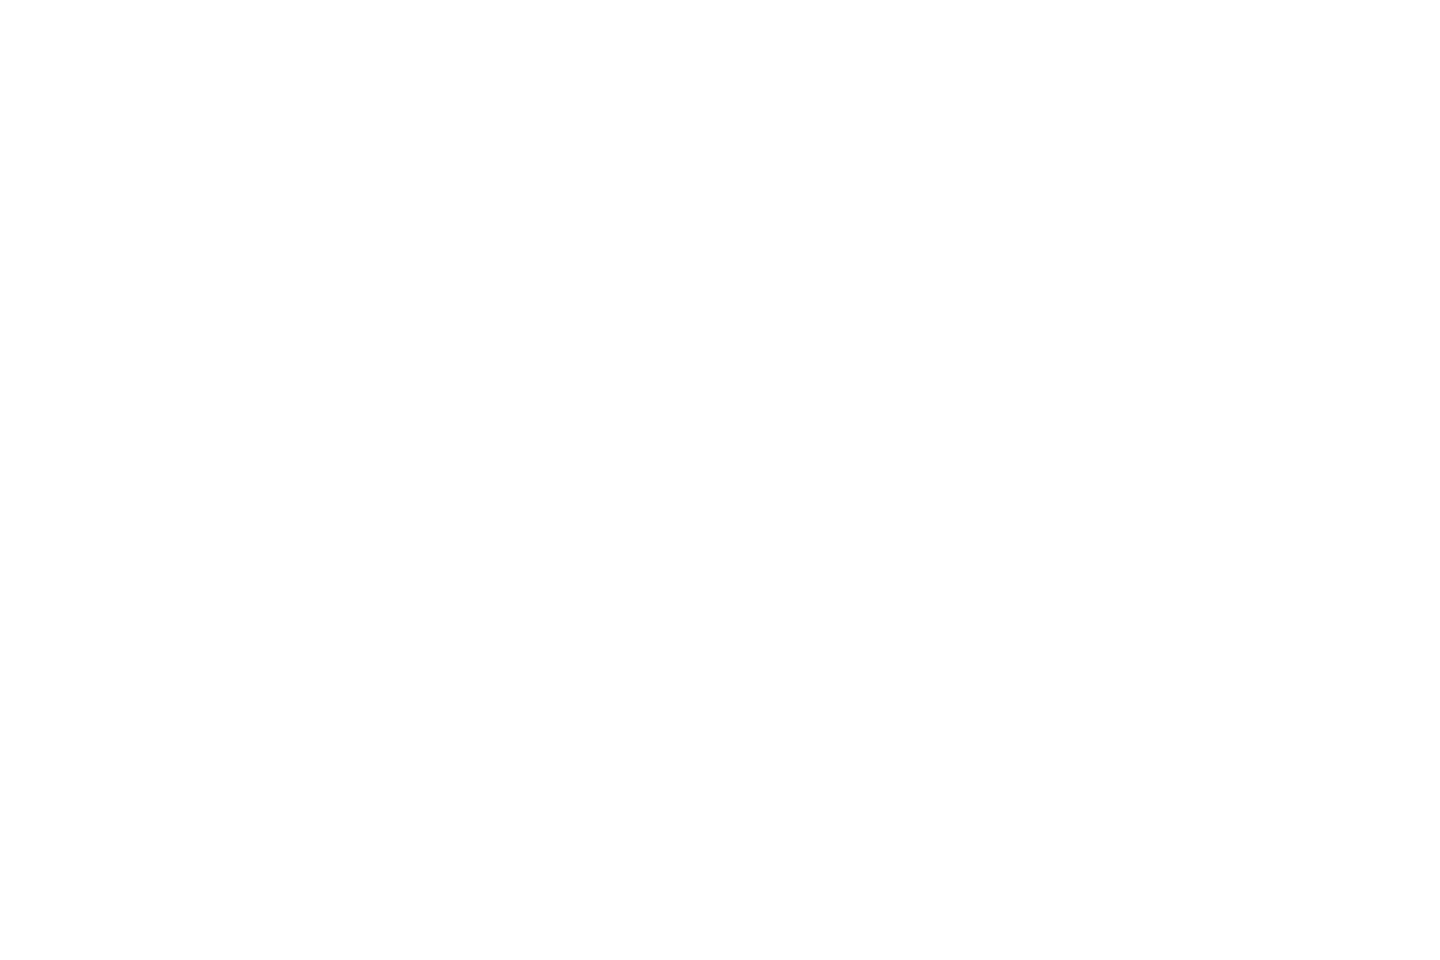

<IPython.core.display.Javascript object>


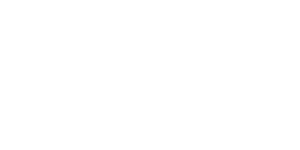

<IPython.core.display.Javascript object>


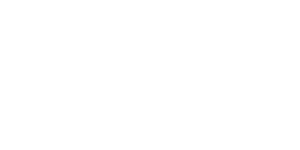

<IPython.core.display.Javascript object>


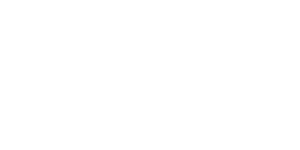

<IPython.core.display.Javascript object>


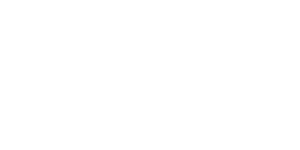

<IPython.core.display.Javascript object>


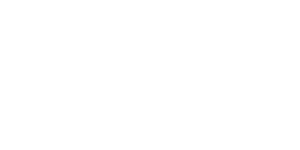

<IPython.core.display.Javascript object>


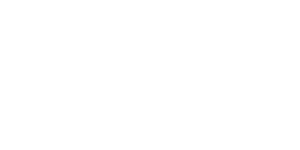

<IPython.core.display.Javascript object>


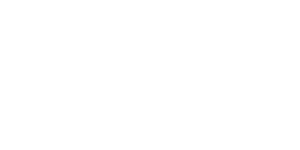

<IPython.core.display.Javascript object>


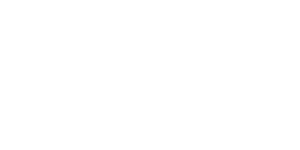

<IPython.core.display.Javascript object>


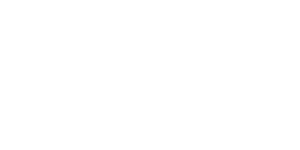

<IPython.core.display.Javascript object>


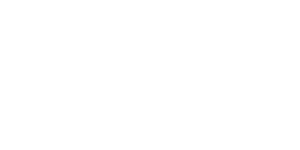

<IPython.core.display.Javascript object>


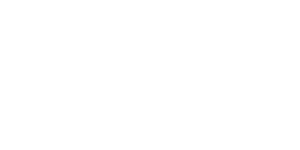

<IPython.core.display.Javascript object>


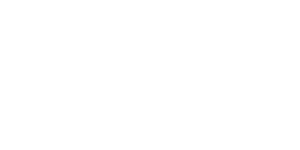

<IPython.core.display.Javascript object>


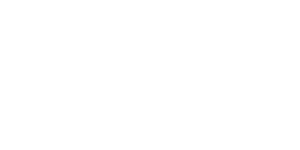

<IPython.core.display.Javascript object>


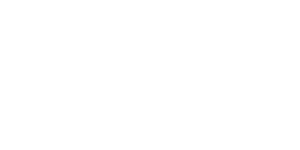

<IPython.core.display.Javascript object>


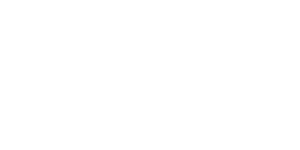

<IPython.core.display.Javascript object>


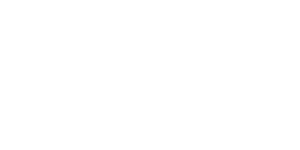

<IPython.core.display.Javascript object>


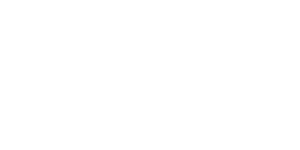

<IPython.core.display.Javascript object>


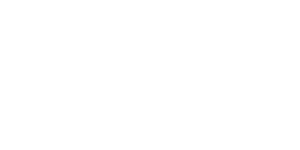

<IPython.core.display.Javascript object>


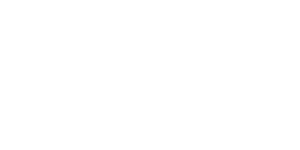

<IPython.core.display.Javascript object>


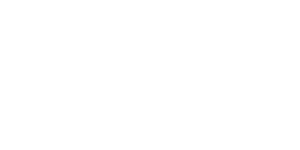

<IPython.core.display.Javascript object>


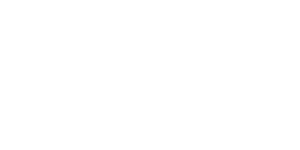

<IPython.core.display.Javascript object>


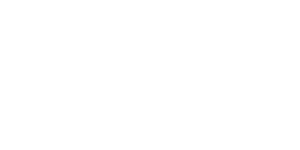

<IPython.core.display.Javascript object>


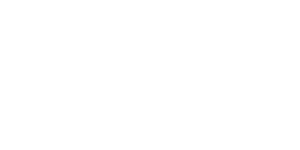

<IPython.core.display.Javascript object>


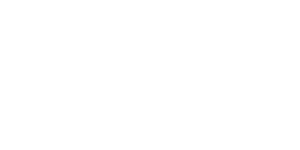

<IPython.core.display.Javascript object>


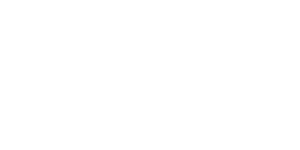

<IPython.core.display.Javascript object>


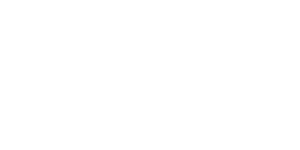

<IPython.core.display.Javascript object>


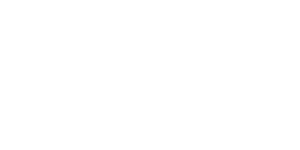

<IPython.core.display.Javascript object>


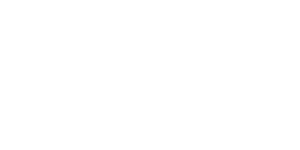

<IPython.core.display.Javascript object>


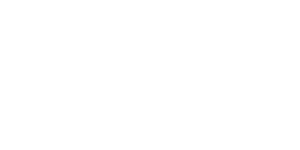

<IPython.core.display.Javascript object>


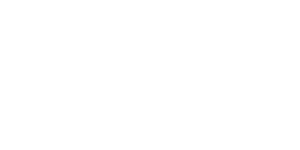

<IPython.core.display.Javascript object>


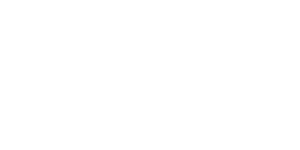

<IPython.core.display.Javascript object>


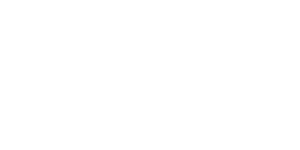

<IPython.core.display.Javascript object>


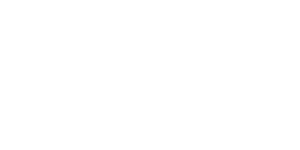

<IPython.core.display.Javascript object>


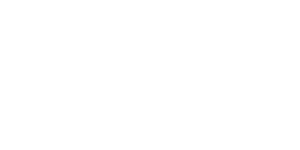

<IPython.core.display.Javascript object>


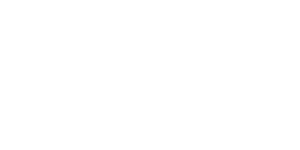

<IPython.core.display.Javascript object>


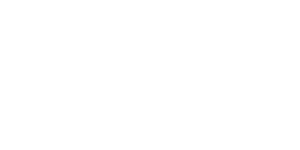

<IPython.core.display.Javascript object>


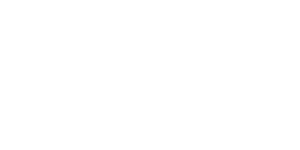

<IPython.core.display.Javascript object>


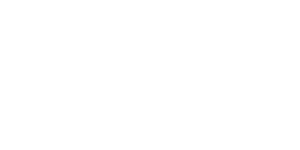

<IPython.core.display.Javascript object>


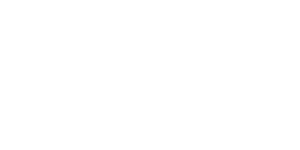

<IPython.core.display.Javascript object>


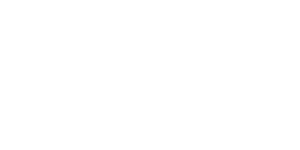

<IPython.core.display.Javascript object>


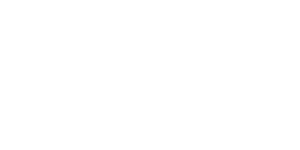

<IPython.core.display.Javascript object>


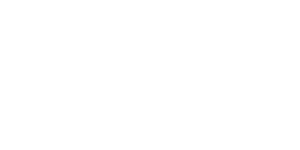

<IPython.core.display.Javascript object>


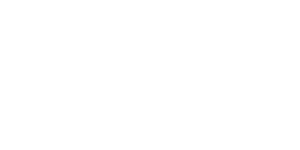

<IPython.core.display.Javascript object>


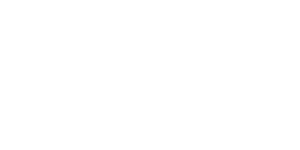

<IPython.core.display.Javascript object>


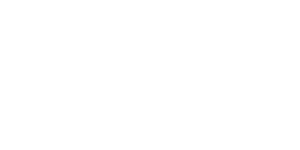

<IPython.core.display.Javascript object>


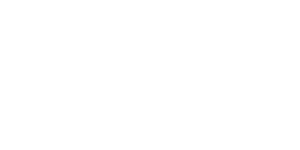

<IPython.core.display.Javascript object>


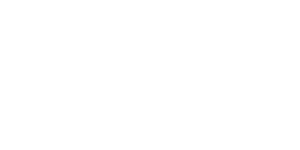

<IPython.core.display.Javascript object>


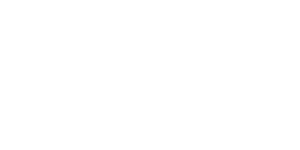

<IPython.core.display.Javascript object>


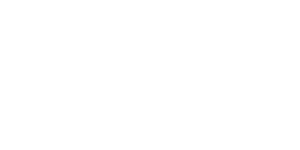

<IPython.core.display.Javascript object>


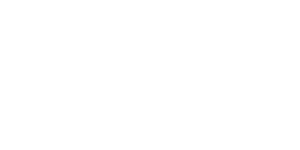

In [128]:
#### for each analysis event - plot one TFR averaged across all epochs for every electrode & save 

for event in analysis_evs: 
    print('Plot TFR for epoch: ',event)
    save_path = f'{tfr_dir}{event}/'
    os.makedirs(save_path,exist_ok = True) #added so you don't have to manually make folders
    
    ev_data = power_epochs[event].copy() # tfr plot data - epochs x num ch x freqs x times 
    times = ev_data.times.copy() # same for all elec
    
    for ch in ev_data.ch_names:
        # single ch tfr 
        plot_data = np.nanmean(np.nanmean(ev_data.copy().pick_channels([ch]).data, axis=0), axis=0) 
        
        fig, ax = plt.subplots(1, 1, figsize=(6, 4),dpi=300)
        
        im = ax.imshow(plot_data,interpolation='Bicubic',
                       aspect='auto', origin='lower', cmap='RdBu_r')
    

        ax.set(xlabel='Time (s)', ylabel='Frequency (Hz)',title=f'{subj_id}_{ch}_{event}_{date}',
               yticks=np.arange(0,len(freqs))[::5], 
               yticklabels=freqs[::5].astype(int), 
               xticks = np.arange(plot_data.shape[1])[::250],
                  xticklabels= times[::250])
        
        fig.colorbar(im, ax=ax)

        plt.savefig(f'{save_path}{subj_id}_{ch}_{event}_{date}.png', dpi=300)
#         bbox_inches=None, pad_inches=0.1,
#         facecolor='auto', edgecolor='auto',backend=None)
        plt.close()

    